In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from eda_utils import *

In [2]:
# set path
import os
os.chdir('..')

In [3]:
# set params for matplotlib and seaborn
set_params()

# get data
data = get_data()

# preprocess data
data = preprocess_data(data)

data

   AmountSold_by_Kilo  AvgPrice_per_Kilo  AvgPrice_per_Kilo_raw  YearNum  \
0         2385.445111           7.075204               6.900461     2023   
1          215.003039           3.797553               3.703762     2023   
2           32.658689           4.023598               3.924224     2023   
3         5855.430868           5.244240               5.114718     2023   
4         1518.629061           5.696330               5.555642     2023   

   MonthNum FishGroup Country  
0         1       Cod     USA  
1         1   Haddock     USA  
2         1       Cod     USA  
3         1   Haddock     USA  
4         1      Hake     USA  
OUTLIERS:
      YYYY/MM FishGroup    Country  AmountSold_by_Kilo  AvgPrice_per_Kilo  \
2340  2022-03       Cod  FAROE IS.                64.0          80.019582   

     Imported  
2340      Yes  


YYYY/MM FishGroup    Country  AmountSold_by_Kilo  AvgPrice_per_Kilo  \
0     2004-01       Cod        USA        37891.790876           7.319704   
1     2004-01   Haddock        USA        24066.278996           6.200732   
2     2004-01      Hake        USA       103171.068030           3.464250   
3     2004-01   Pollock        USA        56597.962461           2.336615   
4     2004-01   Redfish        USA         6455.987880           2.994233   
...       ...       ...        ...                 ...                ...   
2671  2024-02   Haddock  FAROE IS.       131298.000000           0.000000   
2672  2024-02   Haddock    ICELAND       165264.000000           0.000000   
2673  2024-02   Haddock     NORWAY       461235.000000           0.000000   
2674  2024-02      Hake      SPAIN          868.000000           0.000000   
2675  2024-02   Pollock    ICELAND         4716.000000           0.000000   

     Imported  
0          No  
1          No  
2          No  
3          No  
4          No  
...       ...  
2671      Yes  
2672      Yes  
2673      Yes  
2674      Yes  
2675      Yes  

[2675 rows x 6 columns]

In [4]:
data.groupby('Country')['AvgPrice_per_Kilo'].mean().sort_values(ascending=False)

Country
LATVIA                16.454649
NORWAY                11.299523
ICELAND                9.106295
GREENLAND              9.016935
GERMANY                8.115373
RUSSIAN FEDERATION     7.767419
NETHERLANDS            7.498221
UNITED KINGDOM         7.339485
POLAND                 7.227666
DENMARK                7.162620
FRANCE                 5.197809
USA                    4.830091
FAROE IS.              4.669137
ITALY                  4.386464
SWEDEN                 4.007383
PORTUGAL               3.972791
SPAIN                  3.323779
MONTENEGRO             3.073820
GREECE                 2.966402
UKRAINE                2.485466
BOSNIA-HERCEGOVINA     2.474164
LITHUANIA              2.451367
ALBANIA                2.365939
CROATIA                2.255892
ROMANIA                2.201510
BULGARIA               2.123726
SERBIA & KOSOVO        1.966979
IRELAND                1.027472
Name: AvgPrice_per_Kilo, dtype: float64

### Countries Fishing In Barents Sea

In [5]:
countries = data['Country'].value_counts()[1:4].index.values
countries

array(['ICELAND', 'NORWAY', 'RUSSIAN FEDERATION'], dtype=object)

### Filter on Countries

In [6]:
data_filtered = data[data['Country'].isin(['USA', 'ICELAND', 'NORWAY', 'RUSSIAN FEDERATION'])]
data_filtered

YYYY/MM FishGroup  Country  AmountSold_by_Kilo  AvgPrice_per_Kilo  \
0     2004-01       Cod      USA        37891.790876           7.319704   
1     2004-01   Haddock      USA        24066.278996           6.200732   
2     2004-01      Hake      USA       103171.068030           3.464250   
3     2004-01   Pollock      USA        56597.962461           2.336615   
4     2004-01   Redfish      USA         6455.987880           2.994233   
...       ...       ...      ...                 ...                ...   
2669  2024-02       Cod  ICELAND       376300.000000           0.000000   
2670  2024-02       Cod   NORWAY        33410.000000           0.000000   
2672  2024-02   Haddock  ICELAND       165264.000000           0.000000   
2673  2024-02   Haddock   NORWAY       461235.000000           0.000000   
2675  2024-02   Pollock  ICELAND         4716.000000           0.000000   

     Imported  
0          No  
1          No  
2          No  
3          No  
4          No  
...       ...  
2669      Yes  
2670      Yes  
2672      Yes  
2673      Yes  
2675      Yes  

[2199 rows x 6 columns]

# Format Data for Regression (pivot tables)

In [7]:
# Drop the 'Country' column
data_without_country = data_filtered.drop('Country', axis=1)

# Create a unique identifier for each fish group by its import status
data_without_country['FishGroup_ImportStatusValue'] = np.where(data_without_country['Imported'] == 'Yes',
                                                          data_without_country['FishGroup'] + "_Imported_USD",
                                                          data_without_country['FishGroup'] + "_Domestic_USD")

# Create a unique identifier for each fish group by its import status
data_without_country['FishGroup_ImportStatusAmount'] = np.where(data_without_country['Imported'] == 'Yes',
                                                          data_without_country['FishGroup'] + "_Imported_Kilos",
                                                          data_without_country['FishGroup'] + "_Domestic_Kilos")

# Pivot the table to have dates as rows and the unique fish group import statuses as columns, with average prices as values
df_value = data_without_country.pivot_table(index='YYYY/MM', 
                                               columns='FishGroup_ImportStatusValue', 
                                               values='AvgPrice_per_Kilo',
                                               aggfunc='mean')
# Pivot the table to have dates as rows and the unique fish group import statuses as columns, with average prices as values
df_amount = data_without_country.pivot_table(index='YYYY/MM', 
                                               columns='FishGroup_ImportStatusAmount', 
                                               values='AmountSold_by_Kilo',
                                               aggfunc='sum')


In [8]:
data_without_country['FishGroup_ImportStatusValue'].unique()

array(['Cod_Domestic_USD', 'Haddock_Domestic_USD', 'Hake_Domestic_USD',
       'Pollock_Domestic_USD', 'Redfish_Domestic_USD', 'Cod_Imported_USD',
       'Haddock_Imported_USD', 'Pollock_Imported_USD',
       'Hake_Imported_USD', 'Redfish_Imported_USD'], dtype=object)

In [9]:
data_without_country['FishGroup_ImportStatusAmount'].unique()

array(['Cod_Domestic_Kilos', 'Haddock_Domestic_Kilos',
       'Hake_Domestic_Kilos', 'Pollock_Domestic_Kilos',
       'Redfish_Domestic_Kilos', 'Cod_Imported_Kilos',
       'Haddock_Imported_Kilos', 'Pollock_Imported_Kilos',
       'Hake_Imported_Kilos', 'Redfish_Imported_Kilos'], dtype=object)

### Check value_df distributions:

In [10]:
df_value

FishGroup_ImportStatusValue  Cod_Domestic_USD  Cod_Imported_USD  \
YYYY/MM                                                           
2004-01                              7.319704               NaN   
2004-02                              5.992340               NaN   
2004-03                              5.638823               NaN   
2004-04                              5.187963               NaN   
2004-05                              6.387870               NaN   
...                                       ...               ...   
2023-10                              5.567376         11.144255   
2023-11                              6.179600          9.380377   
2023-12                              6.994718         12.500403   
2024-01                                   NaN          0.000000   
2024-02                                   NaN          0.000000   

FishGroup_ImportStatusValue  Haddock_Domestic_USD  Haddock_Imported_USD  \
YYYY/MM                                                                   
2004-01                                  6.200732                   NaN   
2004-02                                  4.766498                   NaN   
2004-03                                  5.251238                   NaN   
2004-04                                  4.333446                   NaN   
2004-05                                  3.680049                   NaN   
...                                           ...                   ...   
2023-10                                  4.000811              6.789353   
2023-11                                  3.784247              6.475457   
2023-12                                  4.975382              6.607995   
2024-01                                       NaN              0.000000   
2024-02                                       NaN              0.000000   

FishGroup_ImportStatusValue  Hake_Domestic_USD  Hake_Imported_USD  \
YYYY/MM                                                             
2004-01                               3.464250                NaN   
2004-02                               2.731574                NaN   
2004-03                               3.331689                NaN   
2004-04                               5.264276                NaN   
2004-05                               2.828064                NaN   
...                                        ...                ...   
2023-10                               3.333121                NaN   
2023-11                               4.811846                NaN   
2023-12                               4.811291                NaN   
2024-01                                    NaN                NaN   
2024-02                                    NaN                NaN   

FishGroup_ImportStatusValue  Pollock_Domestic_USD  Pollock_Imported_USD  \
YYYY/MM                                                                   
2004-01                                  2.336615                   NaN   
2004-02                                  2.502419                   NaN   
2004-03                                  2.843353                   NaN   
2004-04                                  3.074942                   NaN   
2004-05                                  1.985744                   NaN   
...                                           ...                   ...   
2023-10                                  5.550890                   NaN   
2023-11                                  5.877426              7.316257   
2023-12                                  5.062514              8.124016   
2024-01                                       NaN              0.000000   
2024-02                                       NaN              0.000000   

FishGroup_ImportStatusValue  Redfish_Domestic_USD  Redfish_Imported_USD  
YYYY/MM                                                                  
2004-01                                  2.994233                   NaN  
2004-02                                  1.852265       

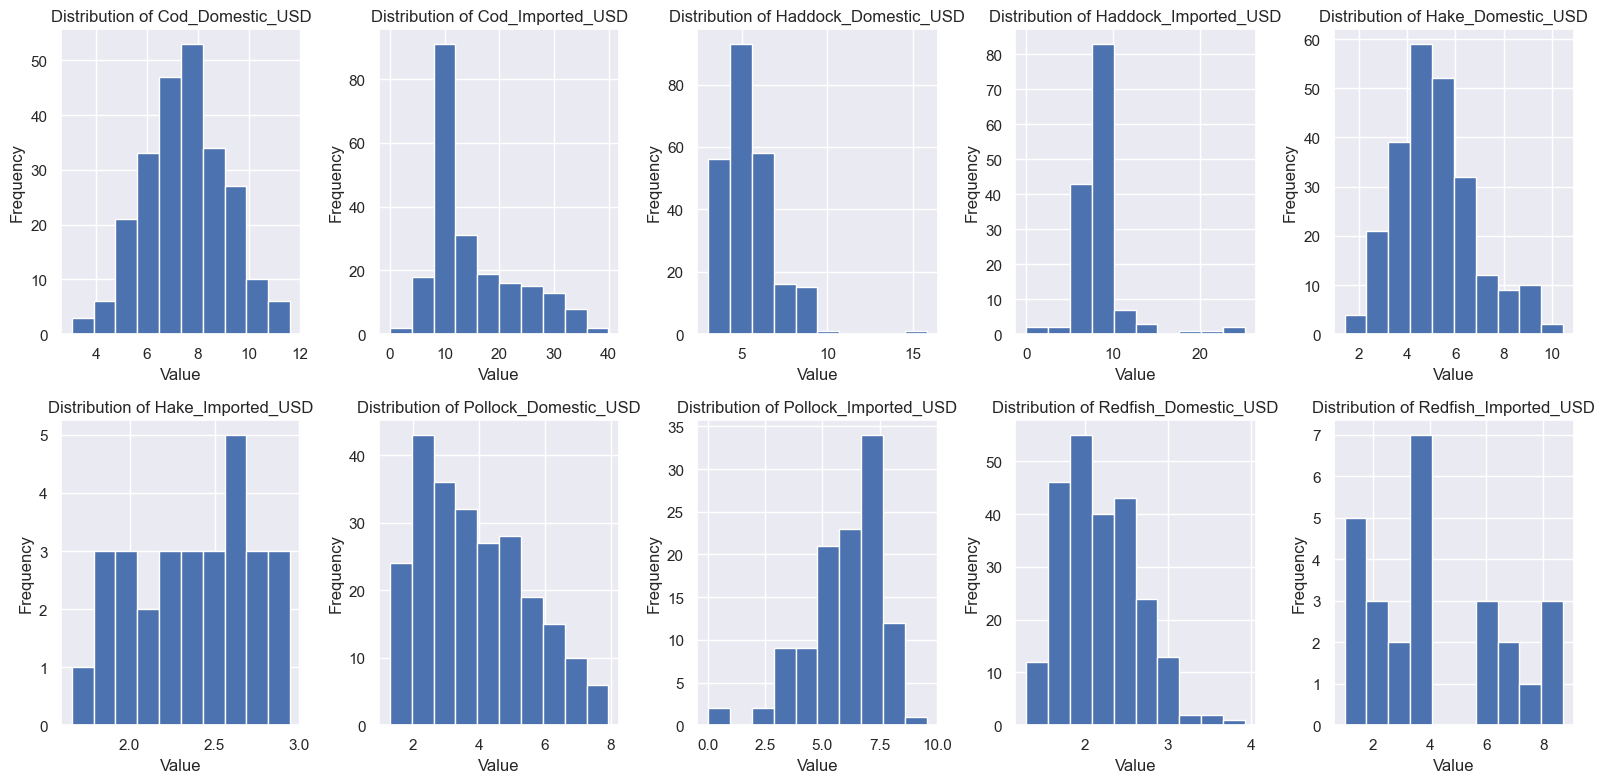

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))

for n, column in enumerate(df_value.columns):
    i = n // 5
    j = n % 5
    ax[i, j].hist(df_value[column], bins=10)  
    ax[i, j].set_title(f'Distribution of {column}')
    ax[i, j].set_xlabel(f'Value')
    ax[i, j].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

### Check amount_df distributions:

In [12]:
df_amount

FishGroup_ImportStatusAmount  Cod_Domestic_Kilos  Cod_Imported_Kilos  \
YYYY/MM                                                                
2004-01                             37891.790876                 NaN   
2004-02                             57071.967051                 NaN   
2004-03                             94923.388158                 NaN   
2004-04                            114840.199218                 NaN   
2004-05                             46999.029311                 NaN   
...                                          ...                 ...   
2023-10                              2737.886801            378040.0   
2023-11                              1918.244414            522584.0   
2023-12                              2224.873221            466942.0   
2024-01                                      NaN            680330.0   
2024-02                                      NaN            409710.0   

FishGroup_ImportStatusAmount  Haddock_Domestic_Kilos  Haddock_Imported_Kilos  \
YYYY/MM                                                                        
2004-01                                 24066.278996                     NaN   
2004-02                                120841.687003                     NaN   
2004-03                                 80199.308724                     NaN   
2004-04                                117251.499125                     NaN   
2004-05                                 30582.594733                     NaN   
...                                              ...                     ...   
2023-10                                 10651.722292                485924.0   
2023-11                                  7394.018017                915477.0   
2023-12                                 15505.166423                715398.0   
2024-01                                          NaN               1014787.0   
2024-02                                          NaN                626499.0   

FishGroup_ImportStatusAmount  Hake_Domestic_Kilos  Hake_Imported_Kilos  \
YYYY/MM                                                                  
2004-01                             103171.068030                  NaN   
2004-02                             139801.417024                  NaN   
2004-03                             160185.428781                  NaN   
2004-04                              99076.031243                  NaN   
2004-05                             149485.625641                  NaN   
...                                           ...                  ...   
2023-10                              13815.986429                  NaN   
2023-11                               6911.848754                  NaN   
2023-12                               5860.420390                  NaN   
2024-01                                       NaN                  NaN   
2024-02                                       NaN                  NaN   

FishGroup_ImportStatusAmount  Pollock_Domestic_Kilos  Pollock_Imported_Kilos  \
YYYY/MM                                                                        
2004-01                                 56597.962461                     NaN   
2004-02                                120811.749871                     NaN   
2004-03                                174808.810589                     NaN   
2004-04                                146683.328646                     NaN   
2004-05                                114421.986556                     NaN   
...                                              ...                     ...   
2023-10                                 14582.558445                     NaN   
2023-11                                  9647.013998                 29212.0   
2023-12                                 16793.823879                  1016.0   
2024-01                                          NaN                 55205.0   
2024-02                                          NaN                  4716.0   

FishGroup_ImportSt

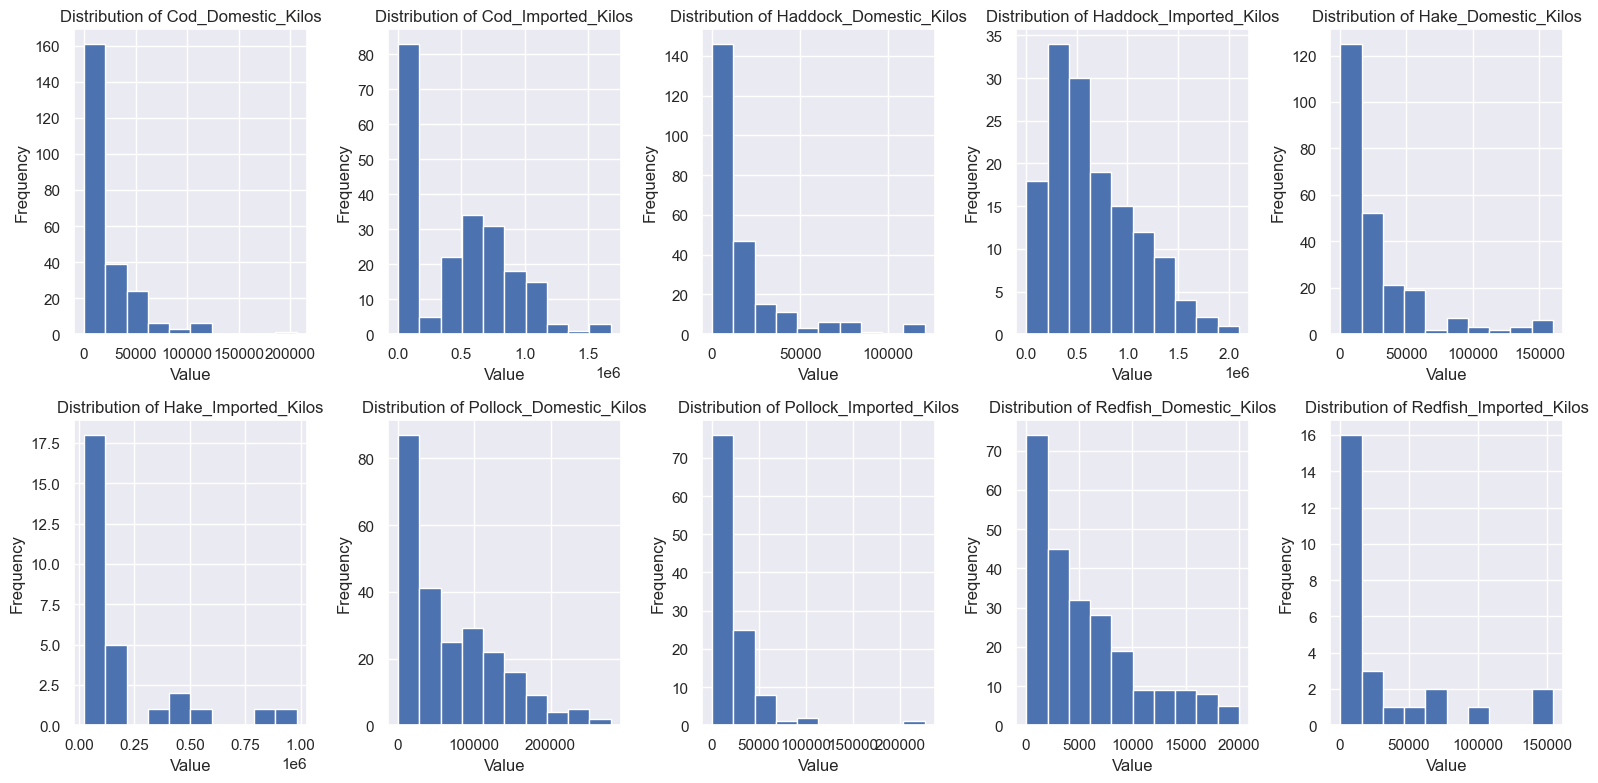

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))

for n, column in enumerate(df_amount.columns):
    i = n // 5
    j = n % 5
    ax[i, j].hist(df_amount[column], bins=10)  
    ax[i, j].set_title(f'Distribution of {column}')
    ax[i, j].set_xlabel(f'Value')
    ax[i, j].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

### Log Transform amount_df:

/var/folders/92/fsnyg0n57cx169y7qtzjg3_w0000gn/T/ipykernel_6602/1342451315.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_amount = df_amount.applymap(lambda x: np.log(x))


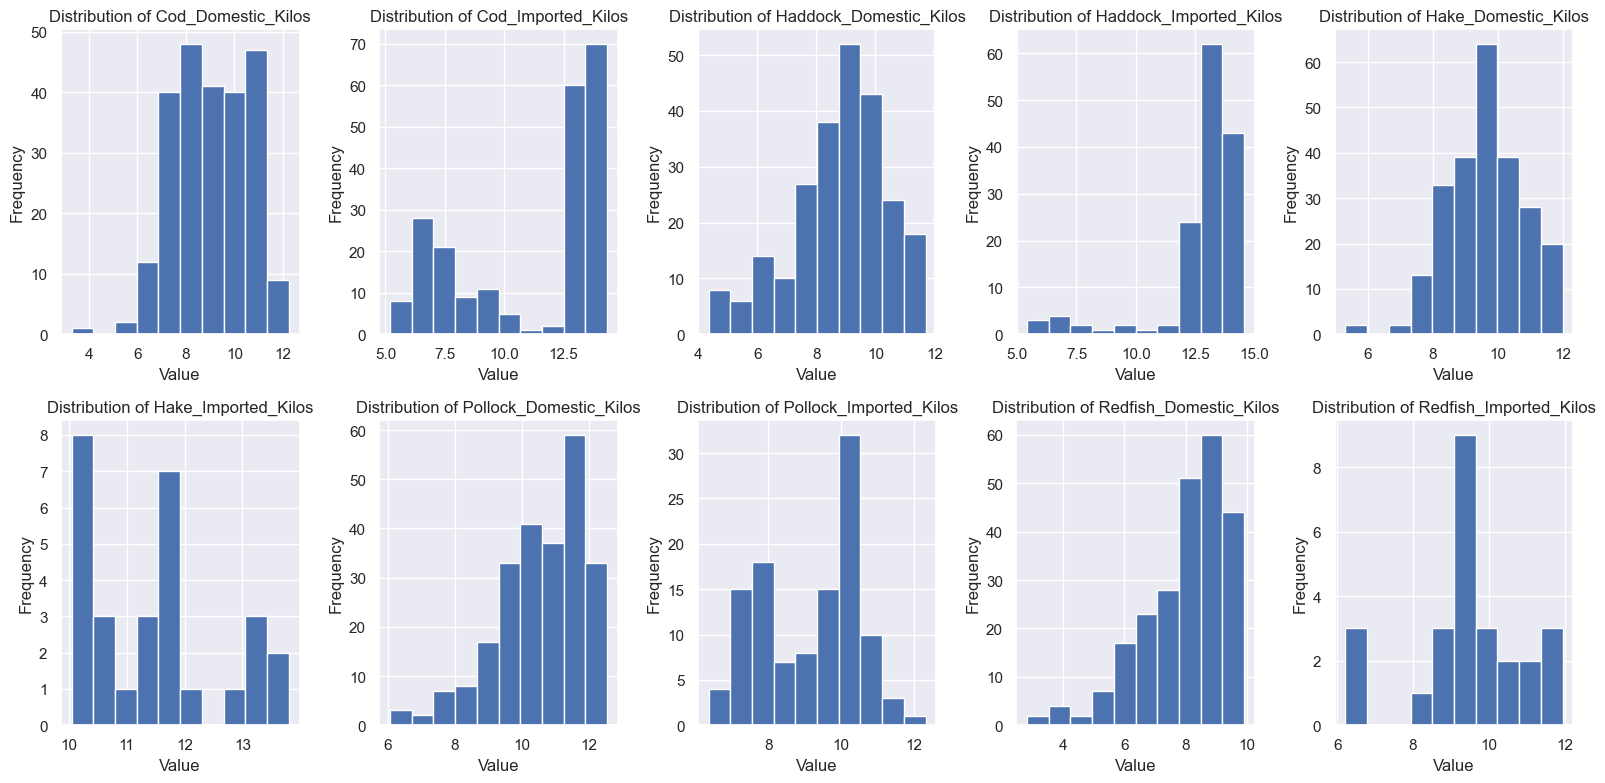

In [14]:
log_transform_amount = True
if log_transform_amount:
    df_amount = df_amount.applymap(lambda x: np.log(x))

    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))

    for n, column in enumerate(df_amount.columns):
        i = n // 5
        j = n % 5
        ax[i, j].hist(df_amount[column], bins=10)  # Adjust the number of bins as needed
        ax[i, j].set_title(f'Distribution of {column}')
        ax[i, j].set_xlabel(f'Value')
        ax[i, j].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()


In [15]:
df_combined = df_value.join(df_amount)
df_combined

Cod_Domestic_USD  Cod_Imported_USD  Haddock_Domestic_USD  \
YYYY/MM                                                             
2004-01          7.319704               NaN              6.200732   
2004-02          5.992340               NaN              4.766498   
2004-03          5.638823               NaN              5.251238   
2004-04          5.187963               NaN              4.333446   
2004-05          6.387870               NaN              3.680049   
...                   ...               ...                   ...   
2023-10          5.567376         11.144255              4.000811   
2023-11          6.179600          9.380377              3.784247   
2023-12          6.994718         12.500403              4.975382   
2024-01               NaN          0.000000                   NaN   
2024-02               NaN          0.000000                   NaN   

         Haddock_Imported_USD  Hake_Domestic_USD  Hake_Imported_USD  \
YYYY/MM                                                               
2004-01                   NaN           3.464250                NaN   
2004-02                   NaN           2.731574                NaN   
2004-03                   NaN           3.331689                NaN   
2004-04                   NaN           5.264276                NaN   
2004-05                   NaN           2.828064                NaN   
...                       ...                ...                ...   
2023-10              6.789353           3.333121                NaN   
2023-11              6.475457           4.811846                NaN   
2023-12              6.607995           4.811291                NaN   
2024-01              0.000000                NaN                NaN   
2024-02              0.000000                NaN                NaN   

         Pollock_Domestic_USD  Pollock_Imported_USD  Redfish_Domestic_USD  \
YYYY/MM                                                                     
2004-01              2.336615                   NaN              2.994233   
2004-02              2.502419                   NaN              1.852265   
2004-03              2.843353                   NaN              2.381700   
2004-04              3.074942                   NaN              2.374099   
2004-05              1.985744                   NaN              2.467574   
...                       ...                   ...                   ...   
2023-10              5.550890                   NaN              1.296815   
2023-11              5.877426              7.316257              1.629798   
2023-12              5.062514              8.124016              1.521188   
2024-01                   NaN              0.000000                   NaN   
2024-02                   NaN              0.000000                   NaN   

         Redfish_Imported_USD  Cod_Domestic_Kilos  Cod_Imported_Kilos  \
YYYY/MM                                                                 
2004-01                   NaN           10.542490                 NaN   
2004-02                   NaN           10.952068                 NaN   
2004-03                   NaN           11.460825                 NaN   
2004-04                   NaN           11.651297                 NaN   
2004-05                   NaN           10.757882                 NaN   
...                       ...                 ...                 ...   
2023-10              1.791965            7.914942           12.842755   
2023-11                   NaN            7.559166           13.166541   
2023-12                   NaN            7.707455           13.053960   
2024-01                   NaN                 NaN           13.430333   
2024-02                   NaN                 NaN           12.923205   

         Haddock_Domestic_Kilos  Haddock_Imported_Kilos  Hake_Domestic_Kilos  \
YYYY/MM                                                                        
2004-01               10.088567                     NaN            11.54414

<Axes: >

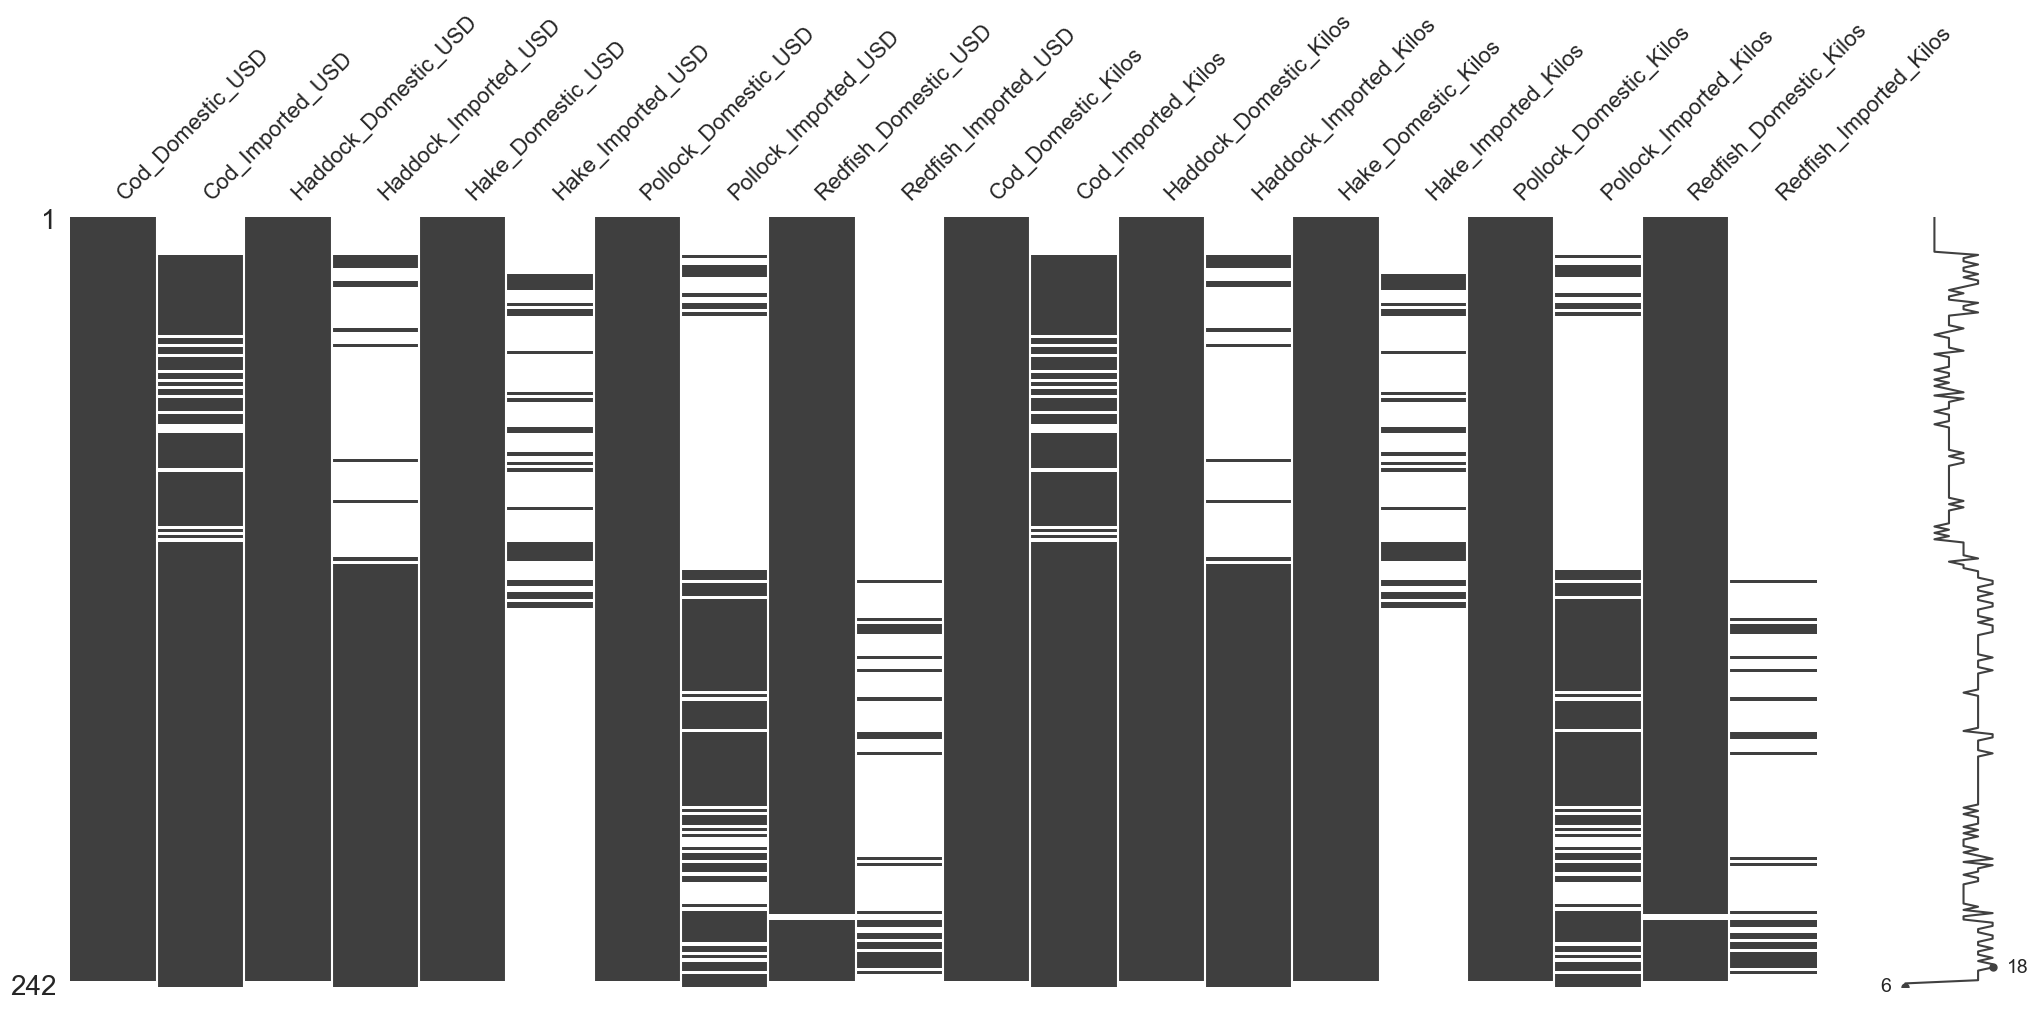

In [16]:
import missingno as msn



msn.matrix(df_combined)


In [17]:
# Filtering the DataFrame for a range of periods
start_period = pd.Period('2014-01', freq='M')
end_period = pd.Period('2024-04', freq='M')
filtered_df_range = df_combined[(df_combined.index >= start_period) & (df_combined.index <= end_period)].copy()


<Axes: >

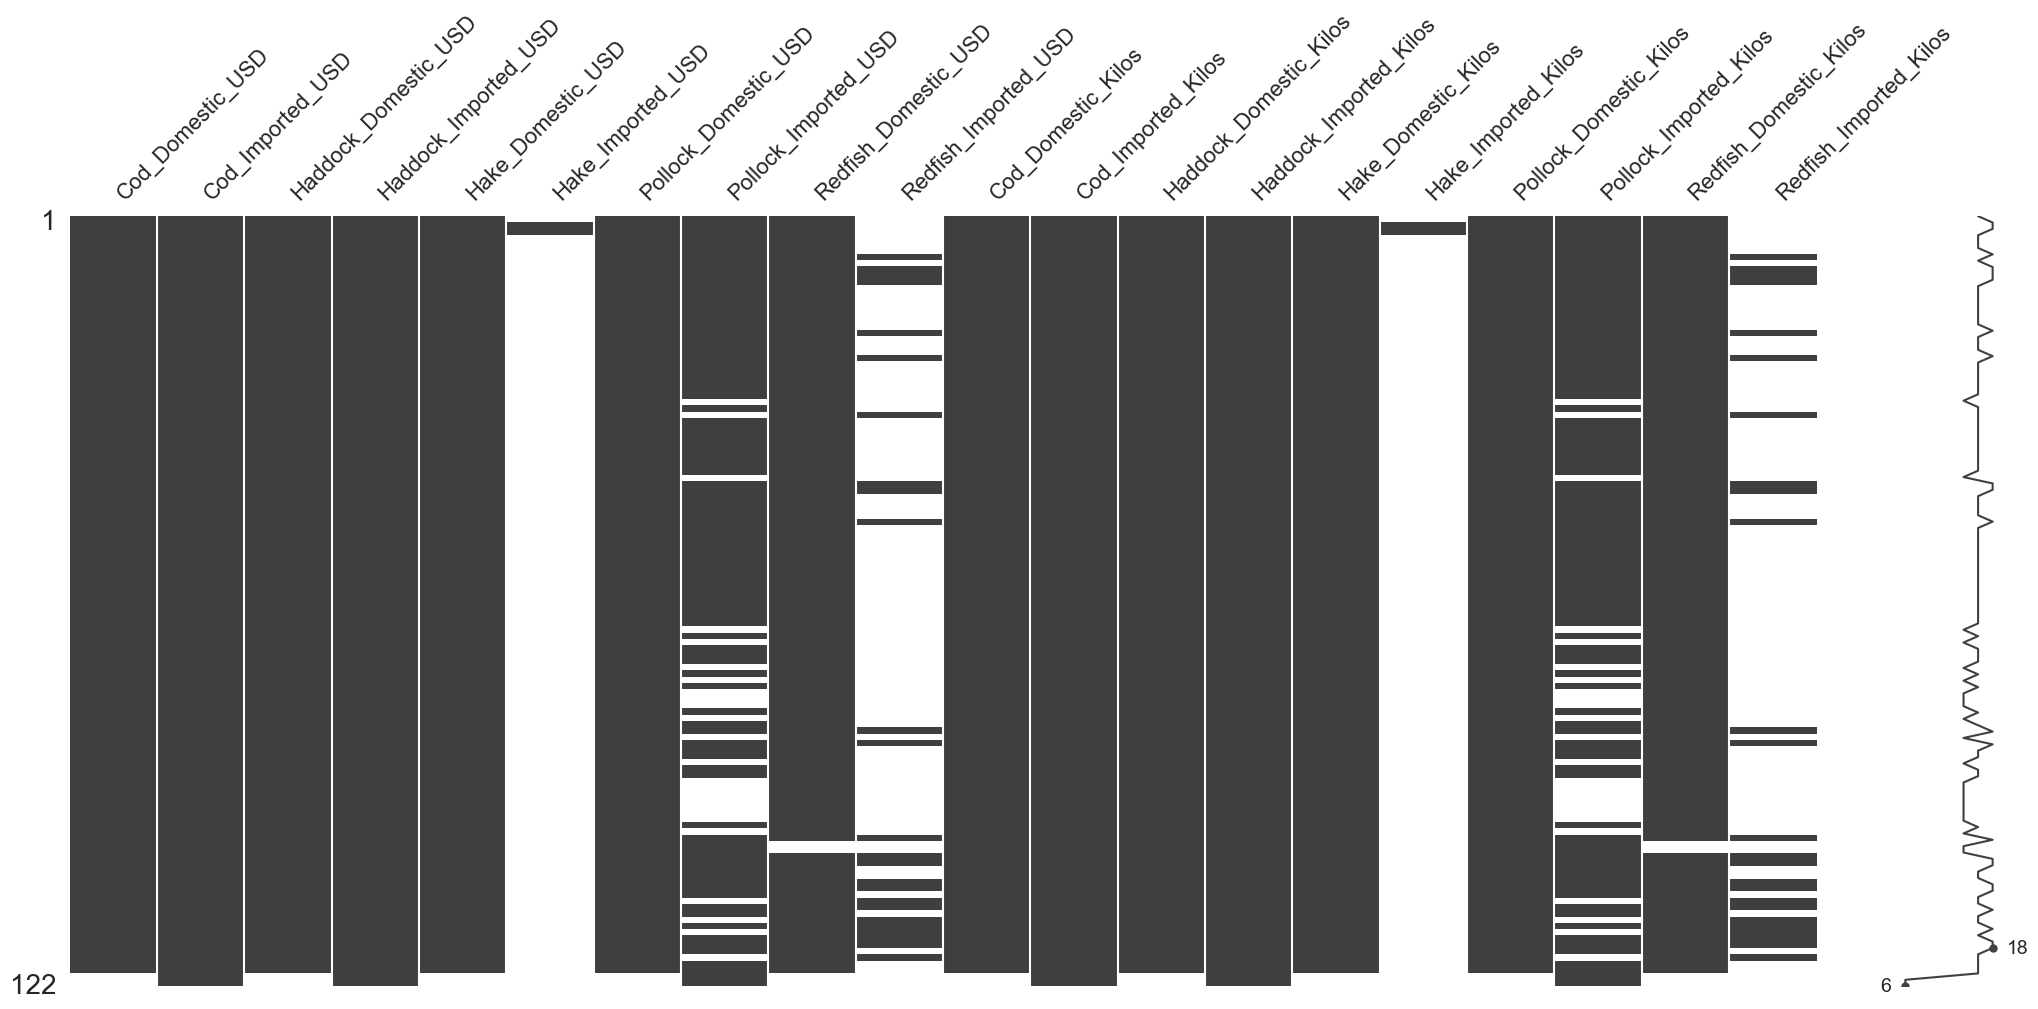

In [18]:
msn.matrix(filtered_df_range)

<Axes: >

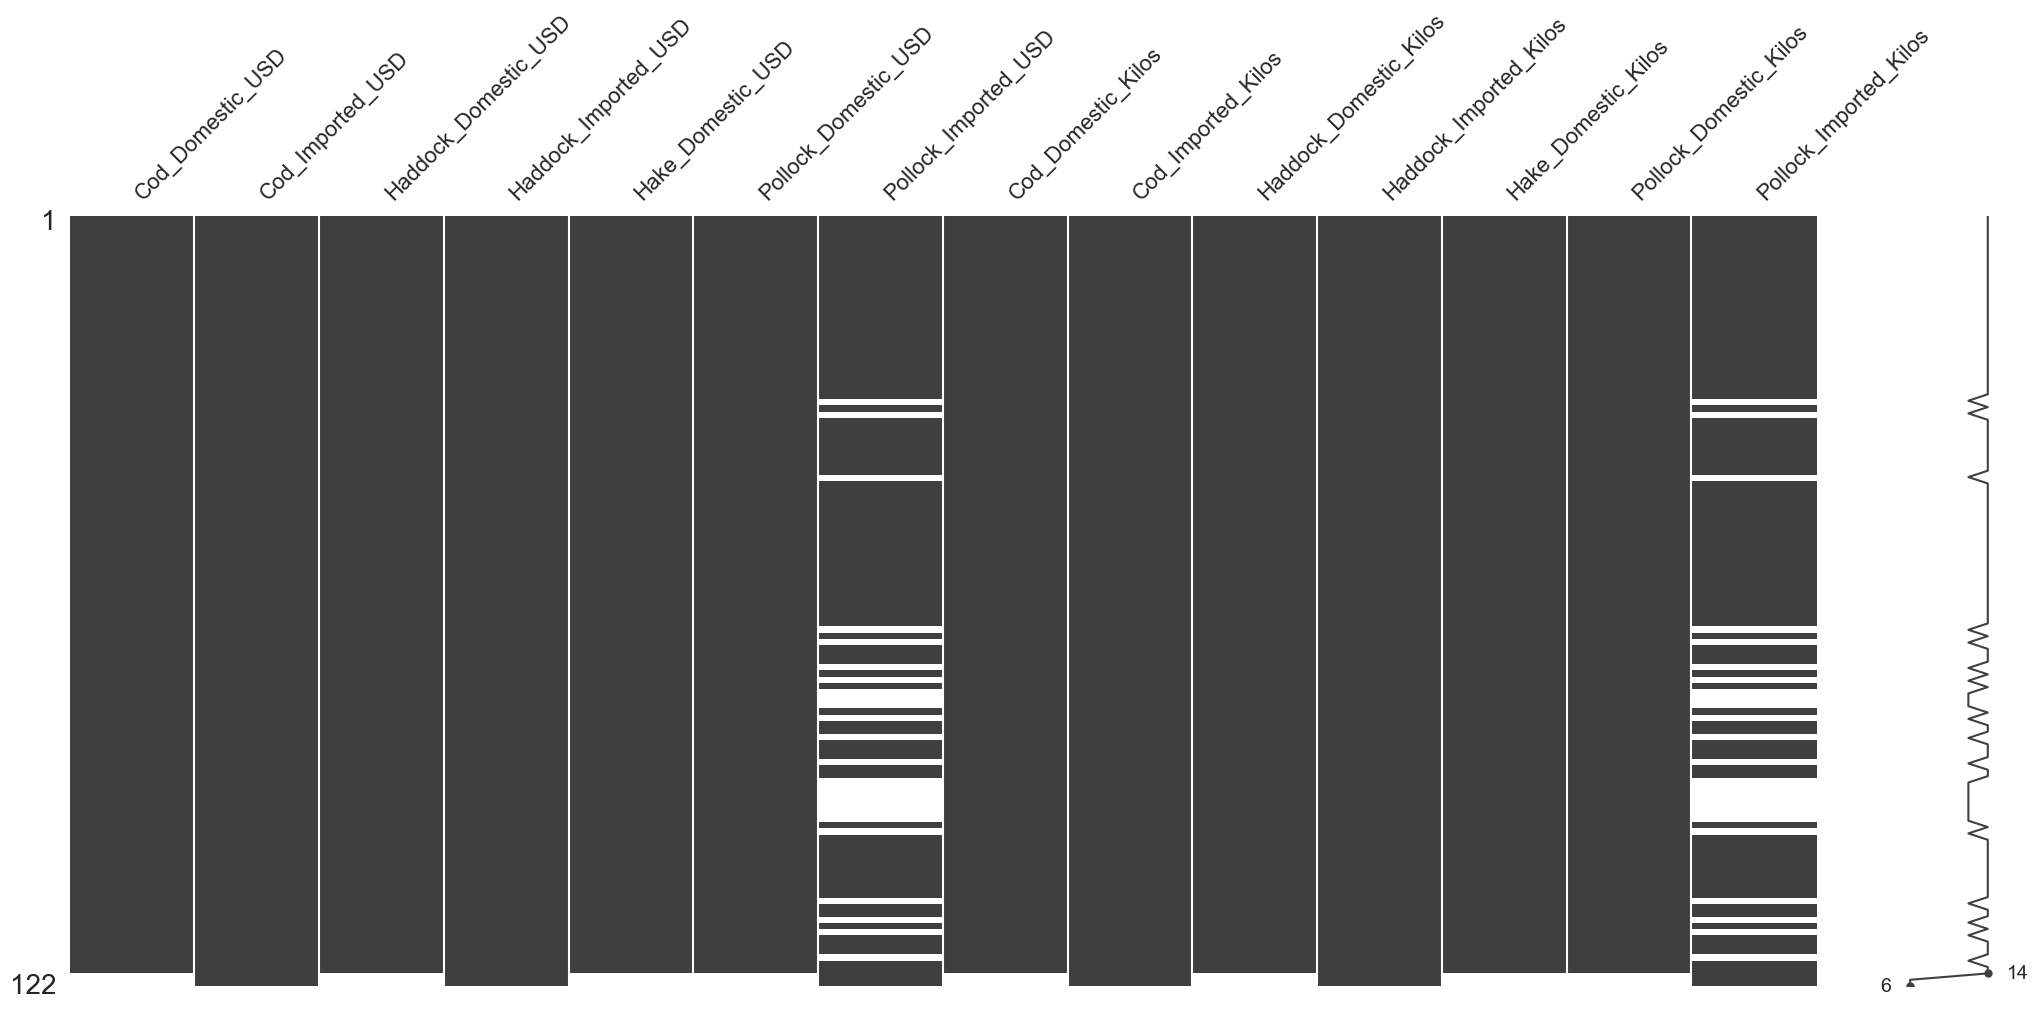

In [19]:
filtered_df_range = filtered_df_range.drop(['Hake_Imported_USD', 'Hake_Imported_Kilos', 'Redfish_Imported_USD', 'Redfish_Domestic_USD', 'Redfish_Domestic_Kilos', 'Redfish_Imported_Kilos'], axis=1)
msn.matrix(filtered_df_range)

# Impute Values for Imported Pollock

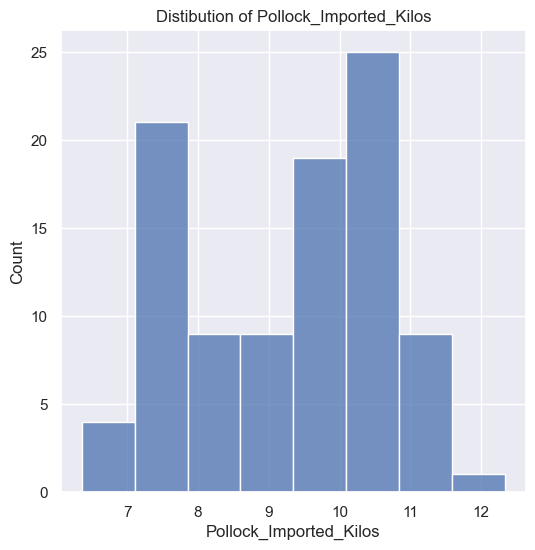

Pollock_Imported_Kilos Mean:  9.218902626635586


In [20]:
plt.figure(figsize=(6, 6))
sns.histplot(data=filtered_df_range, x='Pollock_Imported_Kilos')
plt.title('Distibution of Pollock_Imported_Kilos')
plt.show();
print('Pollock_Imported_Kilos Mean: ', filtered_df_range['Pollock_Imported_Kilos'].mean())

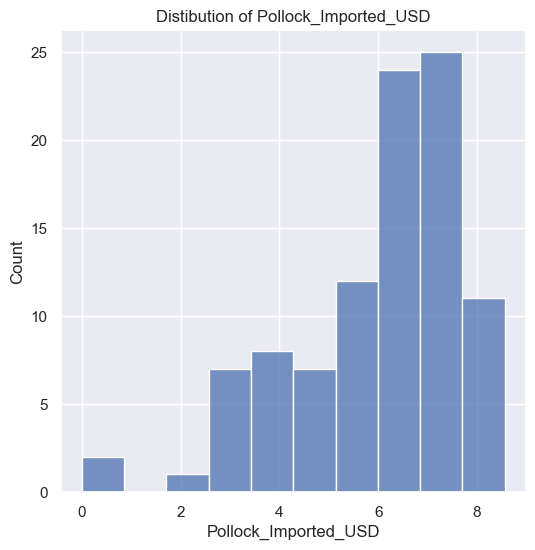

Pollock_Imported_USD Mean:  6.027281016864335


In [21]:
plt.figure(figsize=(6, 6))
sns.histplot(data=filtered_df_range, x='Pollock_Imported_USD')
plt.title('Distibution of Pollock_Imported_USD')
plt.show();

print('Pollock_Imported_USD Mean: ', filtered_df_range['Pollock_Imported_USD'].mean())

In [22]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

cols_to_impute = ['Pollock_Imported_Kilos', 'Pollock_Imported_USD']

filtered_df_range[cols_to_impute] = imp_mean.fit_transform(filtered_df_range[cols_to_impute])

### Drop NaN Values:

<Axes: >

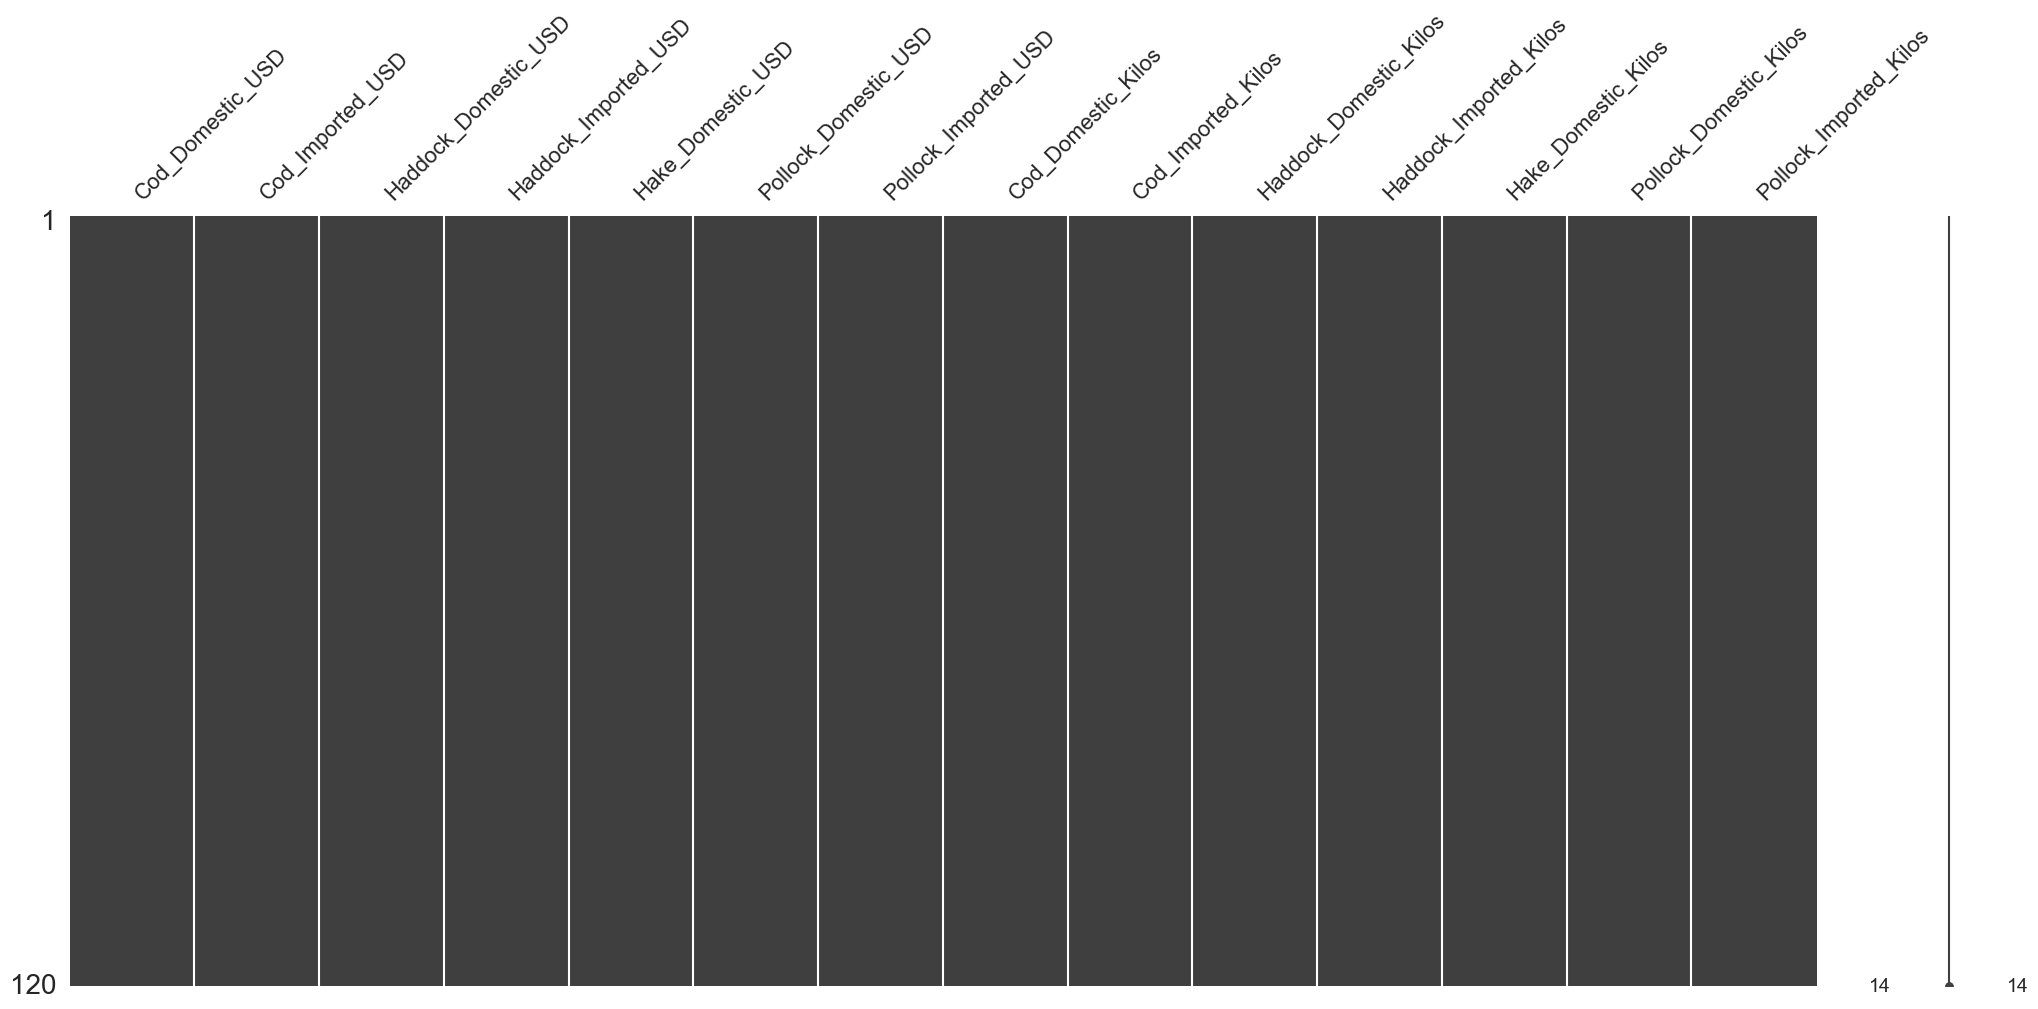

In [23]:
filtered_df_range.dropna(axis=0, inplace=True)
msn.matrix(filtered_df_range)

### Visualize:

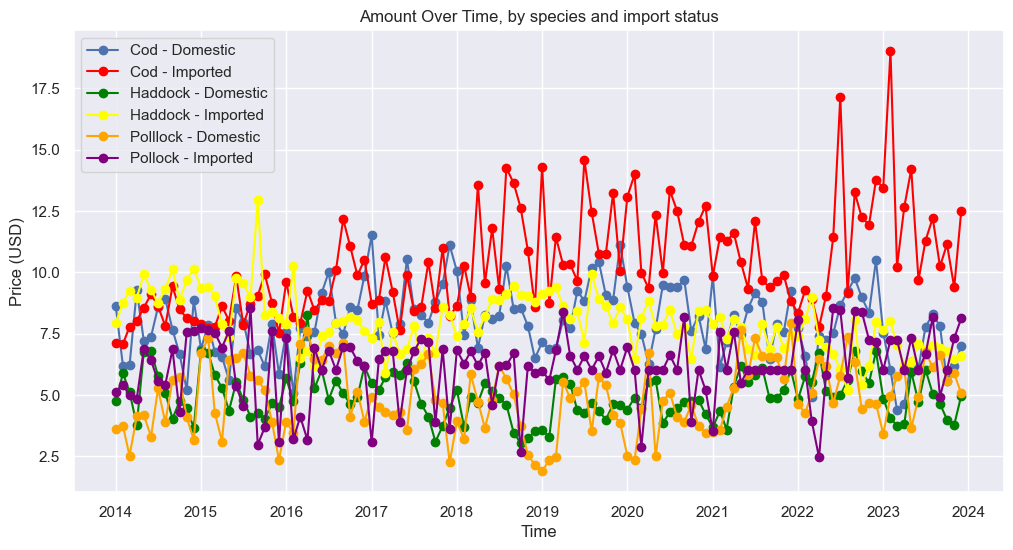

In [24]:
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Cod_Domestic_USD, marker='o', label='Cod - Domestic')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Cod_Imported_USD, marker='o', color='red', label='Cod - Imported')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Haddock_Domestic_USD, marker='o', color='green', label='Haddock - Domestic')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Haddock_Imported_USD, marker='o', color='yellow', label='Haddock - Imported')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Pollock_Domestic_USD, marker='o', color='orange', label='Polllock - Domestic')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Pollock_Imported_USD, marker='o', color='purple', label='Pollock - Imported')
plt.legend()
plt.title('Amount Over Time, by species and import status')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.show();

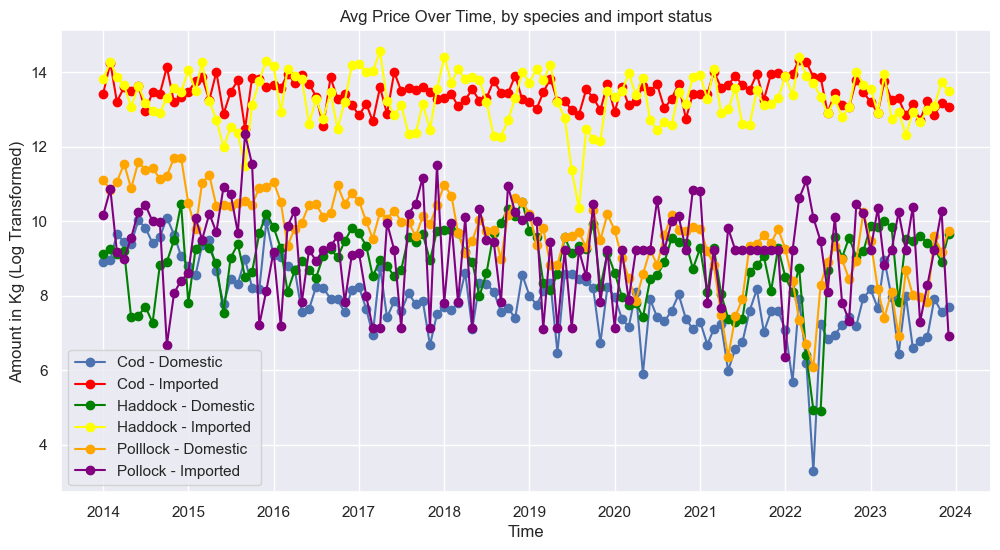

In [25]:
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Cod_Domestic_Kilos, marker='o', label='Cod - Domestic')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Cod_Imported_Kilos, marker='o', color='red', label='Cod - Imported')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Haddock_Domestic_Kilos, marker='o', color='green', label='Haddock - Domestic')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Haddock_Imported_Kilos, marker='o', color='yellow', label='Haddock - Imported')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Pollock_Domestic_Kilos, marker='o', color='orange', label='Polllock - Domestic')
plt.plot(filtered_df_range.index.to_timestamp(), filtered_df_range.Pollock_Imported_Kilos, marker='o', color='purple', label='Pollock - Imported')
plt.legend()
plt.title('Avg Price Over Time, by species and import status')
plt.xlabel('Time')
plt.ylabel('Amount in Kg (Log Transformed)')
plt.show();

# Correlations

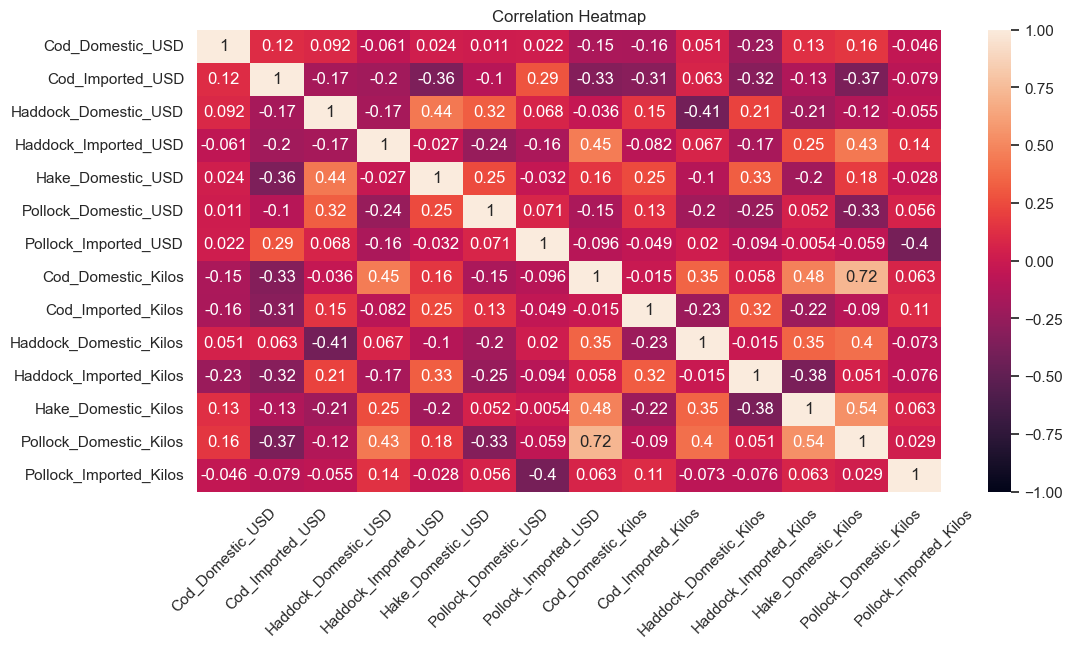

In [26]:
sns.heatmap(filtered_df_range.corr(), vmin=-1, vmax=1, annot=True)
plt.xticks(rotation=45)
plt.title('Correlation Heatmap')
plt.show();

# Pairplots

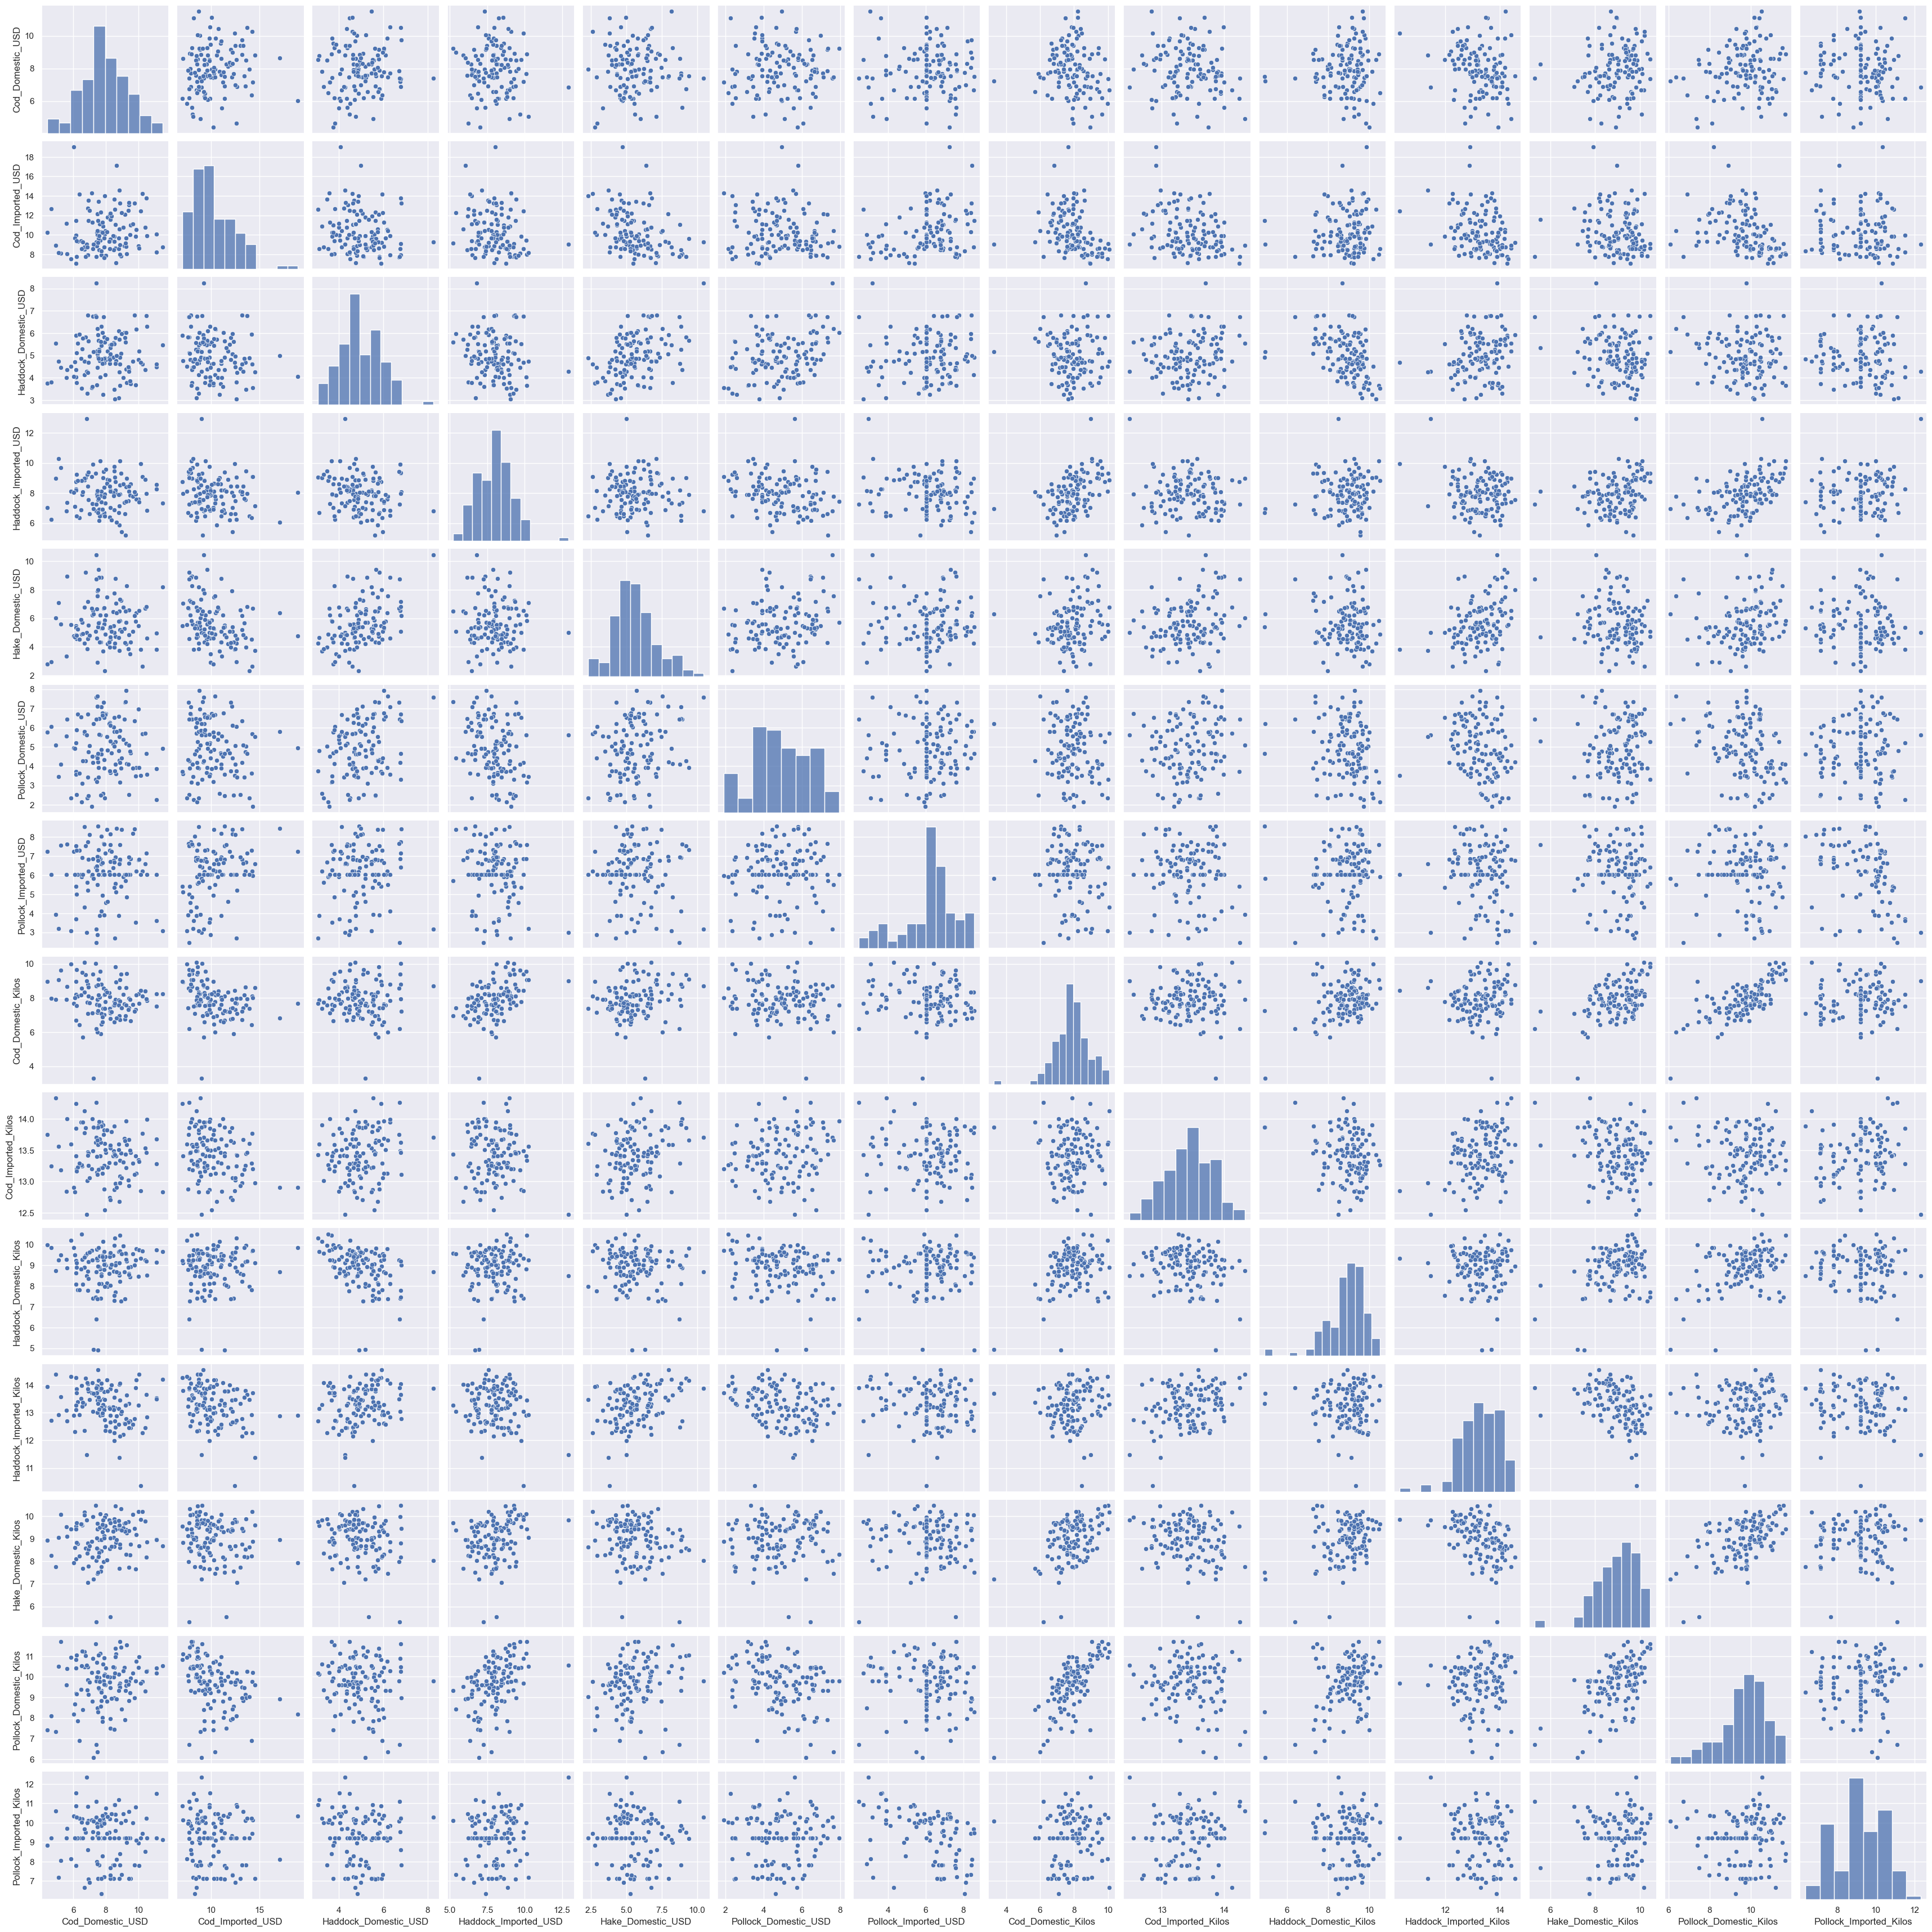

In [27]:
sns.pairplot(data=filtered_df_range)
plt.show();

In [28]:
filtered_df_range.head(10)

Cod_Domestic_USD  Cod_Imported_USD  Haddock_Domestic_USD  \
YYYY/MM                                                             
2014-01          8.608071          7.123507              4.762926   
2014-02          6.172800          7.080431              5.886371   
2014-03          6.206428          7.785099              5.115399   
2014-04          9.265336          8.029334              3.785581   
2014-05          7.205992          8.554649              6.762891   
2014-06          7.374264          9.109100              6.785412   
2014-07          8.589057          8.617010              5.786782   
2014-08          8.929180          7.816033              5.093100   
2014-09          7.660583          9.426712              4.033343   
2014-10          6.682762          8.494858              4.738644   

         Haddock_Imported_USD  Hake_Domestic_USD  Pollock_Domestic_USD  \
YYYY/MM                                                                  
2014-01              7.950334           7.069161              3.612494   
2014-02              8.760383           5.467037              3.726013   
2014-03              9.246262           4.562895              2.526599   
2014-04              8.967970           8.284399              4.129607   
2014-05              9.917645           6.553523              4.184248   
2014-06              9.295776           5.073336              3.307337   
2014-07              8.734152           4.731767              5.265472   
2014-08              9.311596           7.248093              3.884158   
2014-09             10.124563           6.210311              5.614630   
2014-10              8.867269           6.759983              5.719434   

         Pollock_Imported_USD  Cod_Domestic_Kilos  Cod_Imported_Kilos  \
YYYY/MM                                                                 
2014-01              5.117763            8.913566           13.410358   
2014-02              5.396425            8.955694           14.250250   
2014-03              5.004678            9.651675           13.204153   
2014-04              4.857103            9.437983           13.590067   
2014-05              6.864618            9.394194           13.488870   
2014-06              6.418248           10.018000           13.628558   
2014-07              5.560062            9.823133           12.965001   
2014-08              5.414570            9.404743           13.450757   
2014-09              6.860969            9.565058           13.412671   
2014-10              4.303159           10.088133           14.131927   

         Haddock_Domestic_Kilos  Haddock_Imported_Kilos  Hake_Domestic_Kilos  \
YYYY/MM                                                                        
2014-01                9.123526               13.802386             8.829508   
2014-02                9.242380               14.268268             9.565663   
2014-03                9.114381               13.869506             9.692435   
2014-04                9.200760               13.639879             9.263849   
2014-05                7.413296               13.059289             9.984623   
2014-06                7.456141               13.637535            10.463522   
2014-07                7.703779               13.169766            10.457519   
2014-08                7.271878               12.960035            10.325379   
2014-09                8.819232               12.904275            10.111430   
2014-10                8.906769               13.309415            10.177091   

         Pollock_Domestic_Kilos  Pollock_Imported_Kilos  
YYYY/MM                                                  
2014-01               11.101396               10.151636  
2014-02               10.841397               10.857690  
2014-03               11.053248                9.178127  
2014-04               11.537735                8.989694  
2014-05               10.875083                9.546384  
2014-06               11.591129               1

# Feature Matrix and Target Vector

In [29]:
cols = filtered_df_range.columns
X_cols = cols.drop('Pollock_Domestic_USD')
X = filtered_df_range[X_cols]
y = filtered_df_range[['Pollock_Domestic_USD']]


# Regressions

In [30]:
#preprossesing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# models

# model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import mean_squared_error, r2_score

## Simple Linear Regression

### Imported Cod Price vs Domestic Pollock Price

Model score: -0.004698357162721489
Intercept: [4.70096831]
Coefficient: [[0.02457005]]
Mean Squared Error: 2.278831832445714
R-squared: -0.004698357162721489


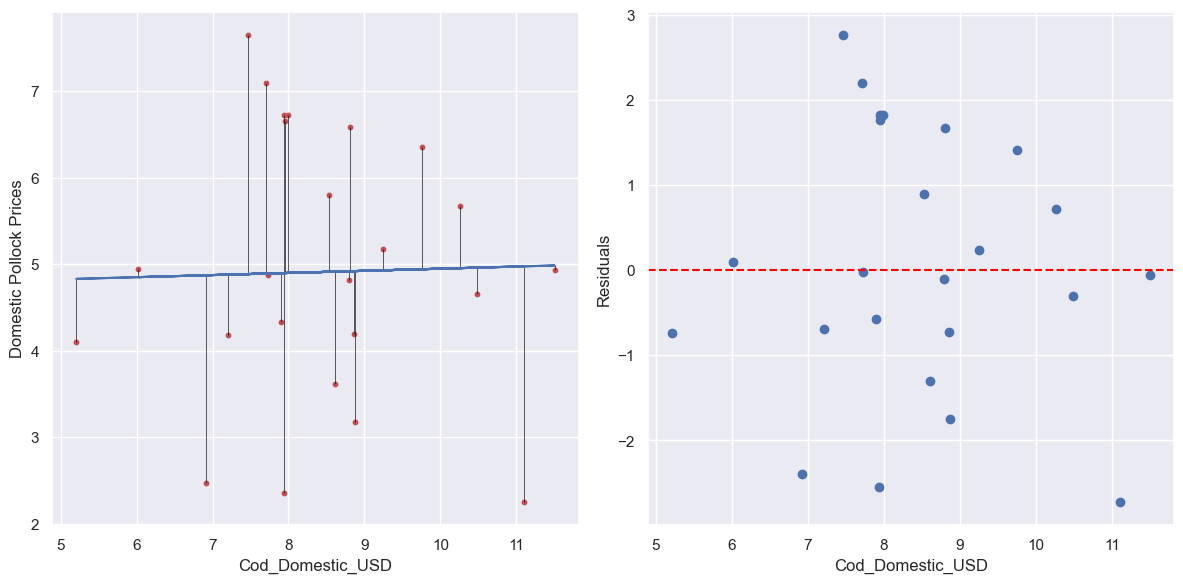

Model score: -0.035076528168078935
Intercept: [5.9317424]
Coefficient: [[-0.10101104]]
Mean Squared Error: 2.347734844583591
R-squared: -0.035076528168078935


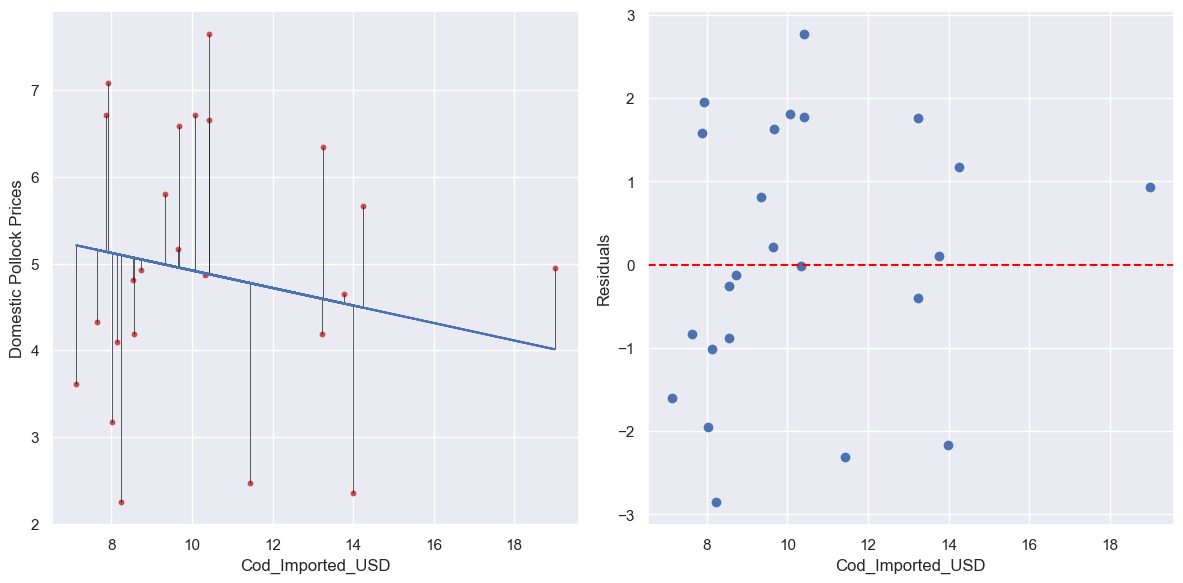

Model score: 0.08905328510367028
Intercept: [2.4336215]
Coefficient: [[0.4989241]]
Mean Squared Error: 2.0661866885399847
R-squared: 0.08905328510367028


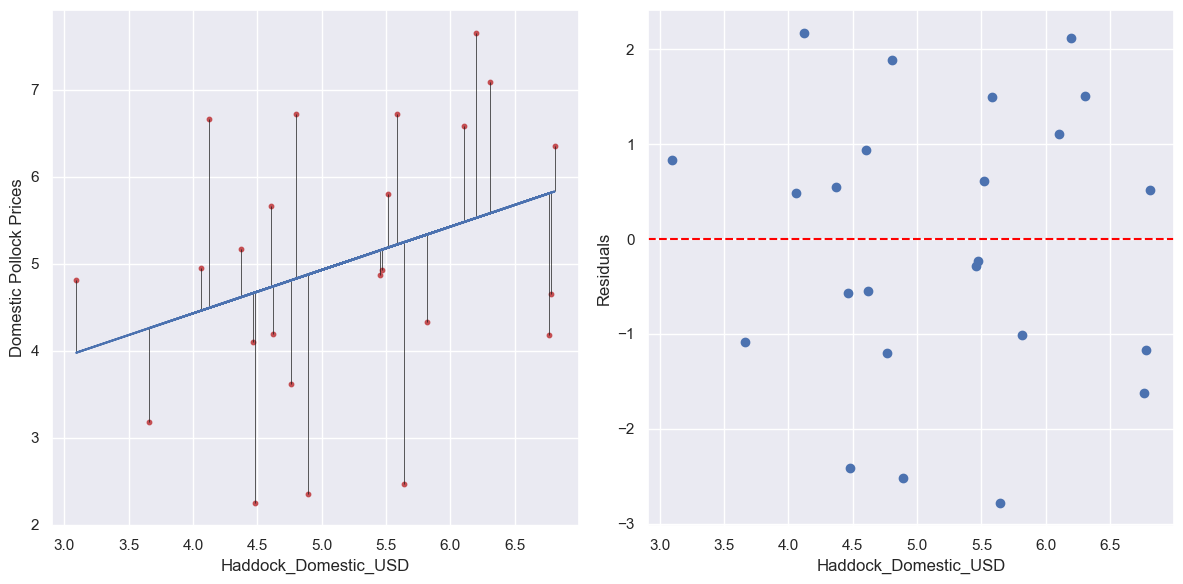

Model score: 0.040960382906003456
Intercept: [7.26440882]
Coefficient: [[-0.29803608]]
Mean Squared Error: 2.1752698135012327
R-squared: 0.040960382906003456


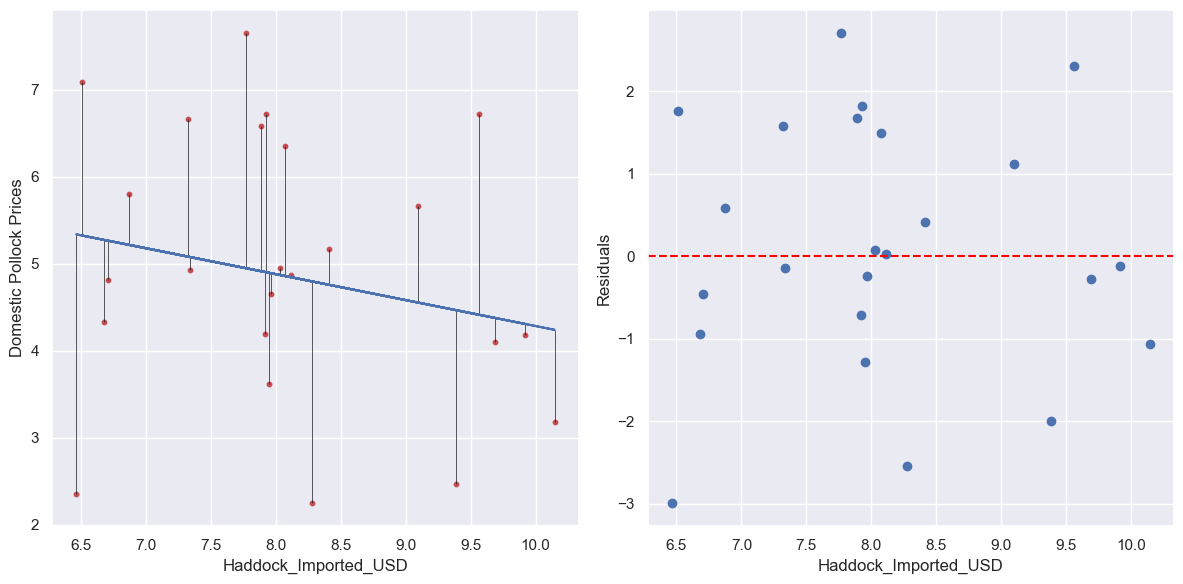

Model score: 0.11773440463984186
Intercept: [3.85756278]
Coefficient: [[0.18487658]]
Mean Squared Error: 2.001132886348266
R-squared: 0.11773440463984186


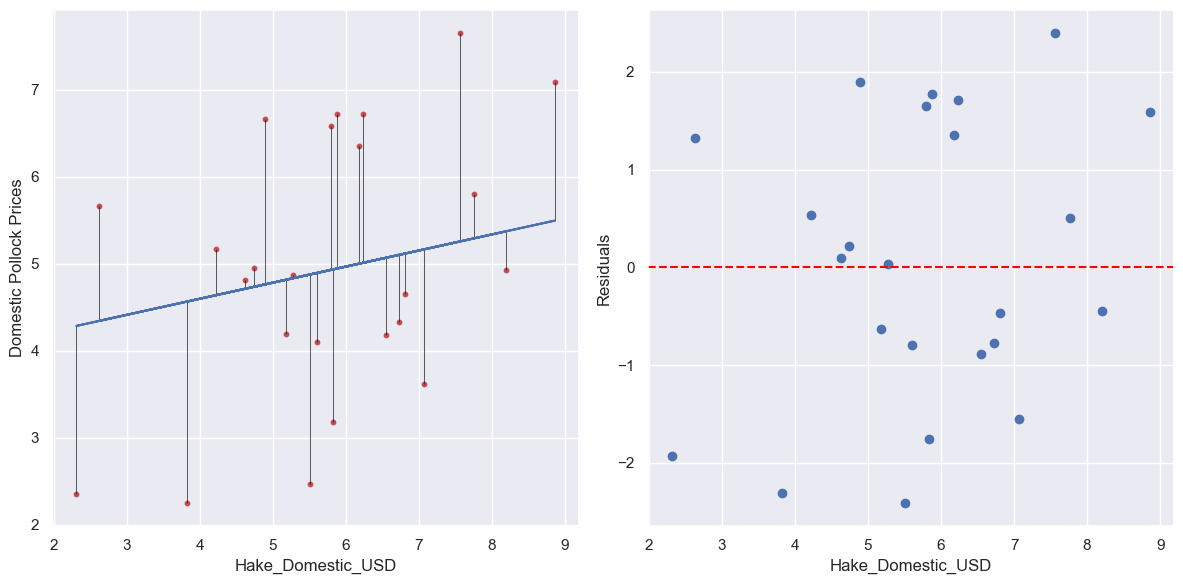

Model score: -0.016061173825822284
Intercept: [4.29152634]
Coefficient: [[0.09740143]]
Mean Squared Error: 2.304604690670787
R-squared: -0.016061173825822284


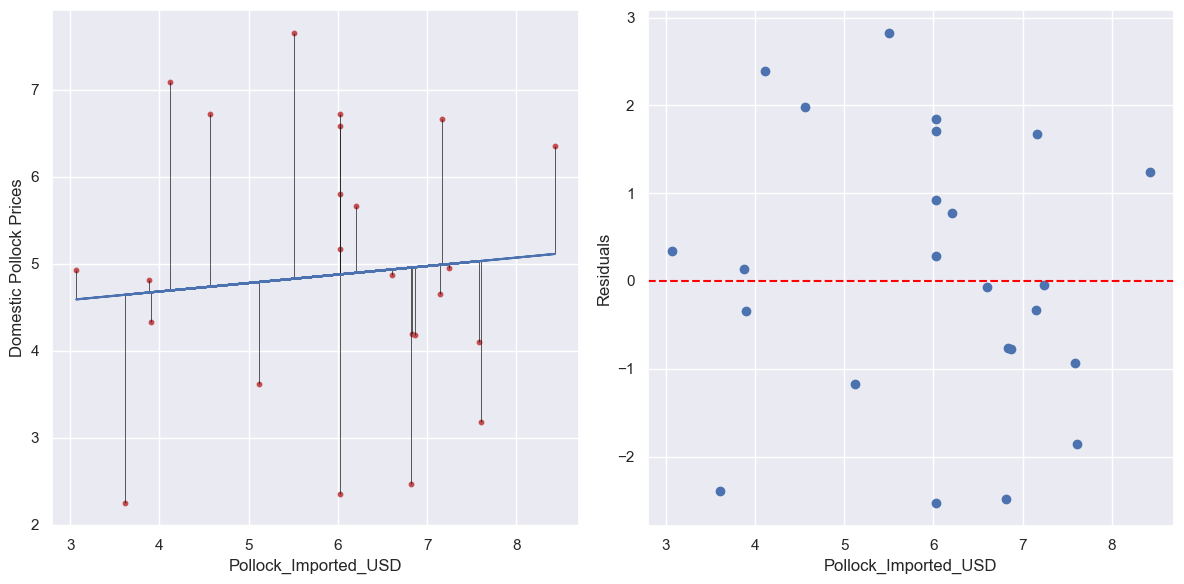

Model score: 0.03361183637273524
Intercept: [6.37862447]
Coefficient: [[-0.18833838]]
Mean Squared Error: 2.1919376040304335
R-squared: 0.03361183637273524


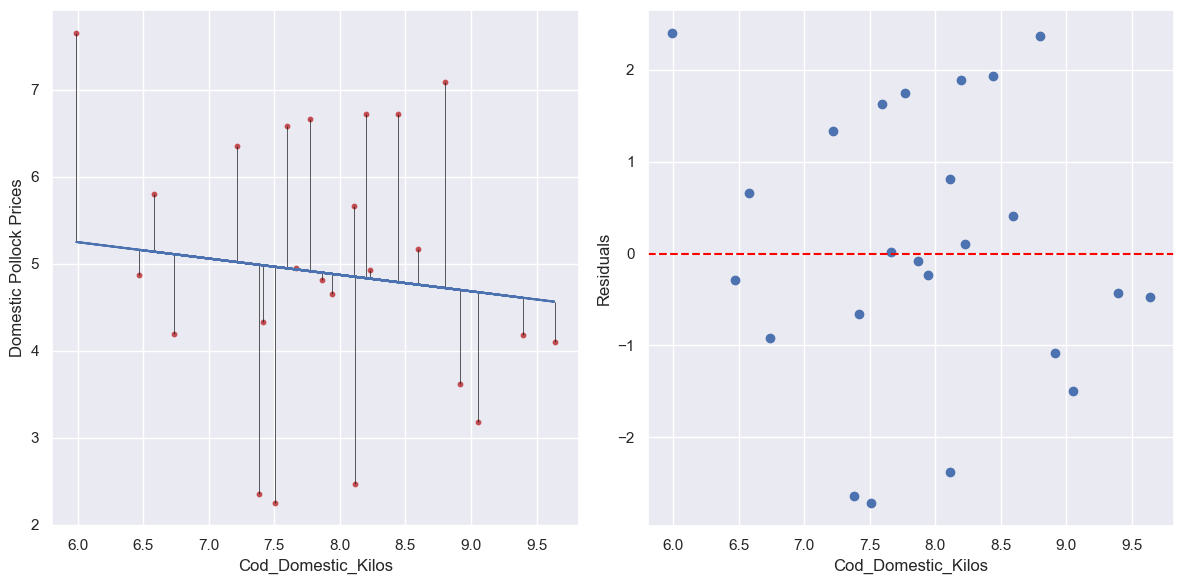

Model score: 0.008907479091250337
Intercept: [-1.83575481]
Coefficient: [[0.50015074]]
Mean Squared Error: 2.247971412956073
R-squared: 0.008907479091250337


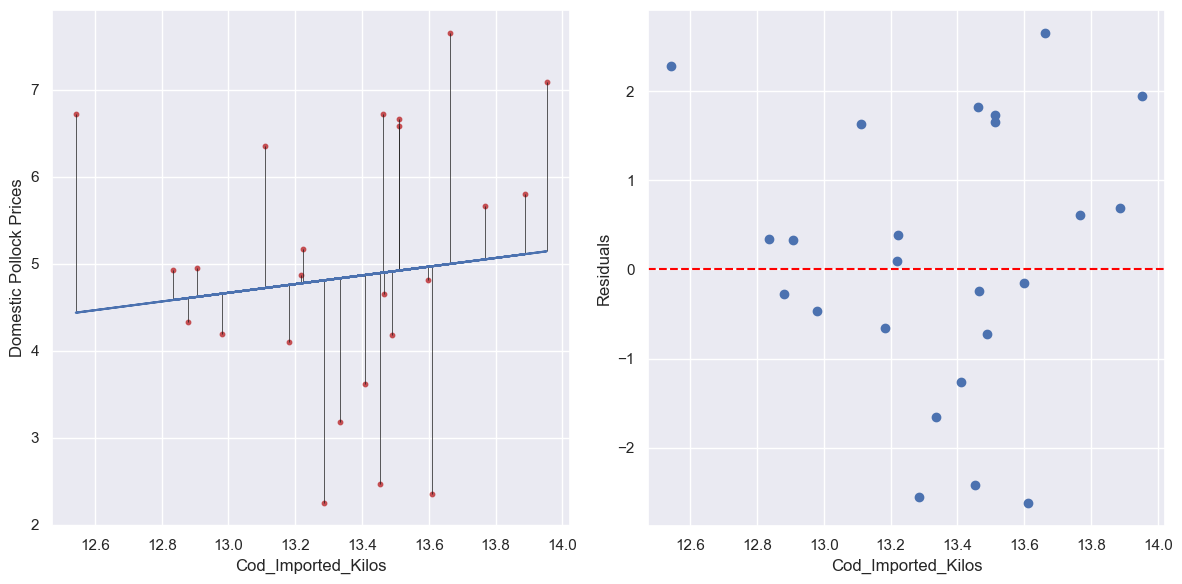

Model score: 0.03408513044075612
Intercept: [7.55328944]
Coefficient: [[-0.29938298]]
Mean Squared Error: 2.1908640901935446
R-squared: 0.03408513044075612


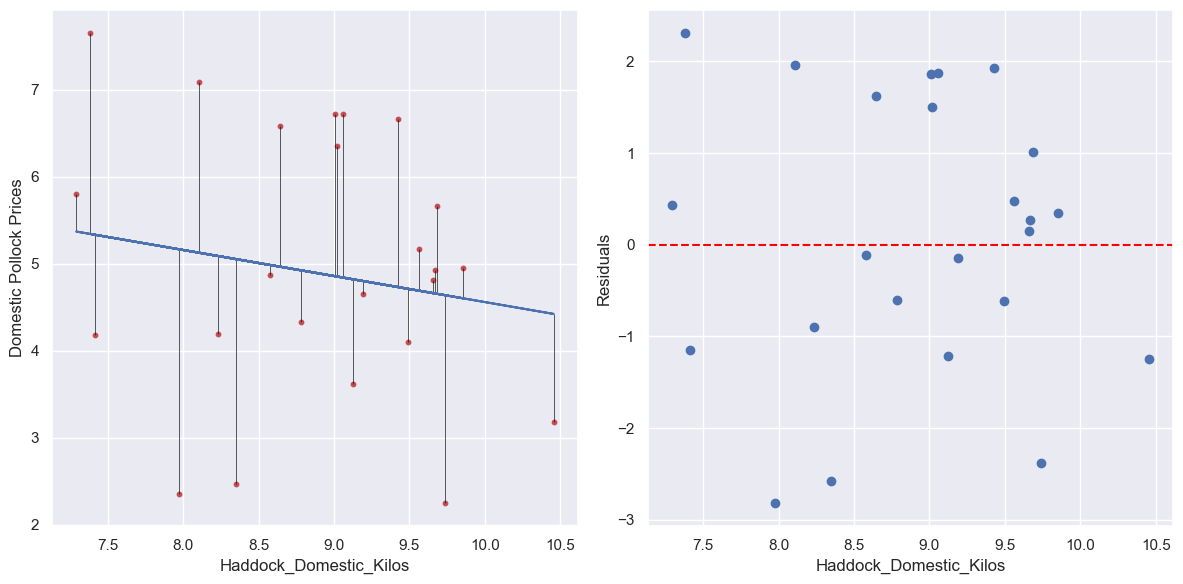

Model score: 0.09997195845952433
Intercept: [10.46461316]
Coefficient: [[-0.41910993]]
Mean Squared Error: 2.0414212251210304
R-squared: 0.09997195845952433


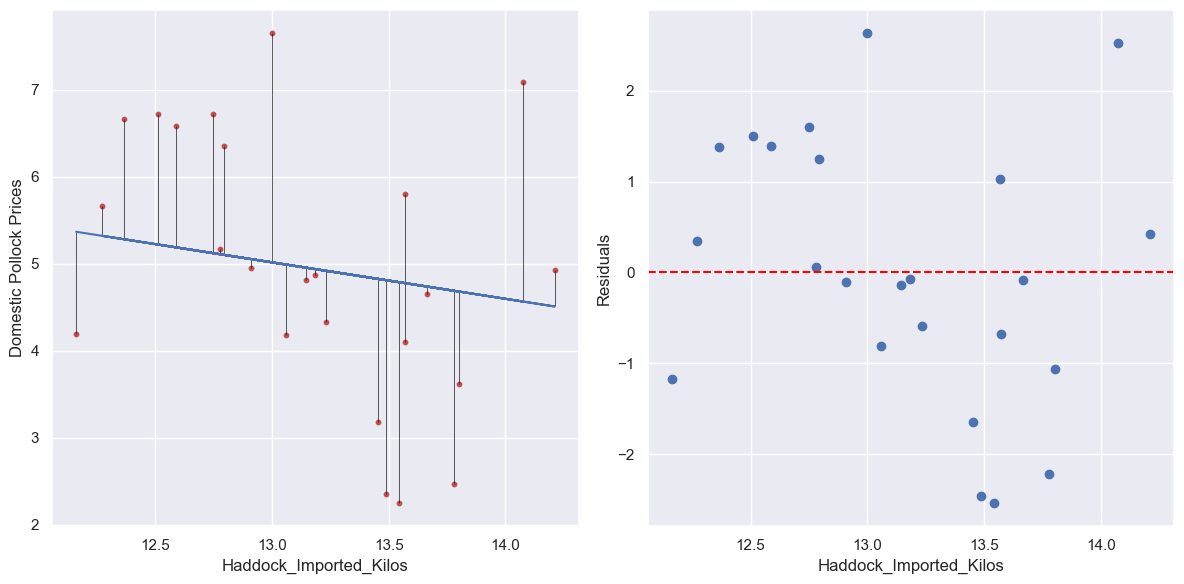

Model score: 0.003989264050012542
Intercept: [4.47348593]
Coefficient: [[0.04694239]]
Mean Squared Error: 2.2591267860239026
R-squared: 0.003989264050012542


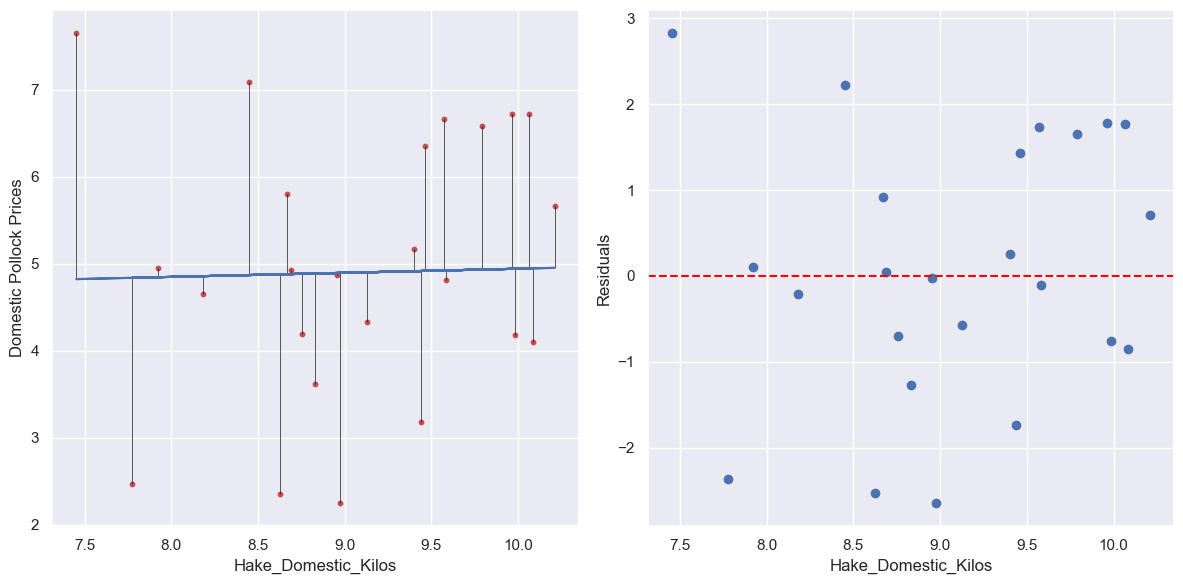

Model score: 0.18113826894465712
Intercept: [8.34903674]
Coefficient: [[-0.35805172]]
Mean Squared Error: 1.8573218178342161
R-squared: 0.18113826894465712


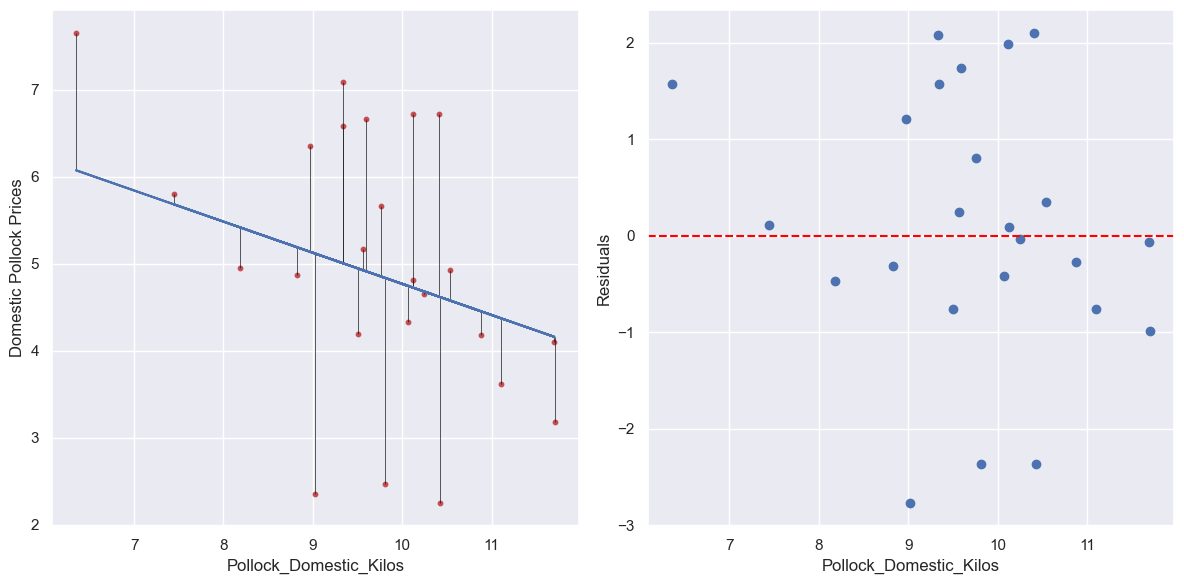

Model score: 0.00514638464139805
Intercept: [4.56426352]
Coefficient: [[0.03585212]]
Mean Squared Error: 2.256502233869688
R-squared: 0.00514638464139805


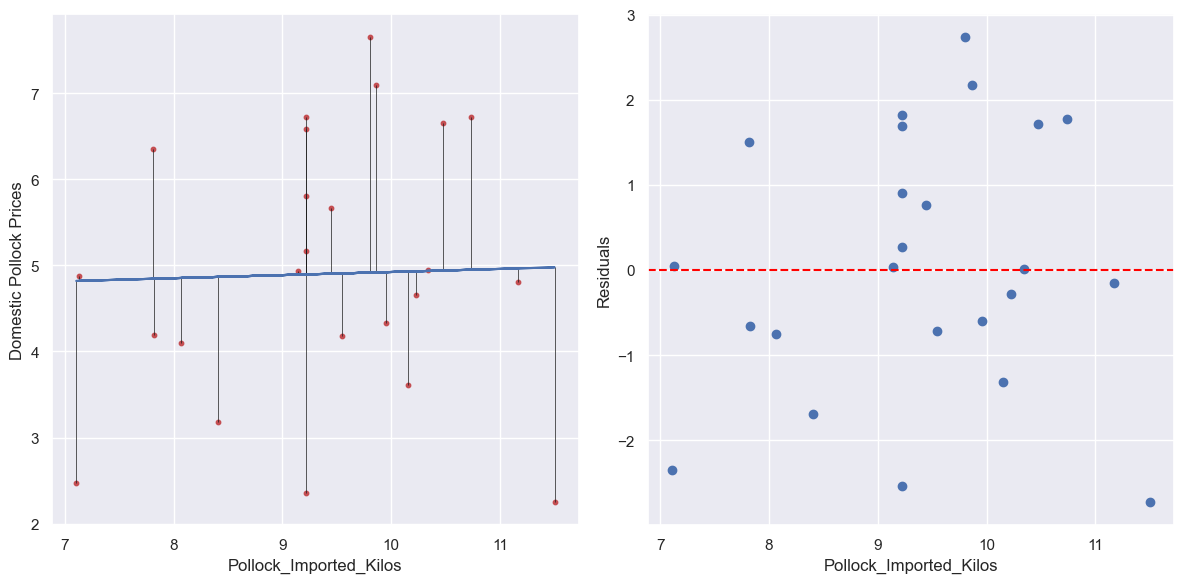

In [31]:
reg_dict_list = []

for col in X:

    X_simple = X[col].values.reshape(-1, 1)

    model = LinearRegression()

    X_train, X_test, y_train, y_test = train_test_split(X_simple, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    score = model.score(X_test, y_test)

    # Calculate and print coefficients
    print("Model score:", score)

    # Calculate and print the intercept and coef
    print("Intercept:", model.intercept_)
    print("Coefficient:", model.coef_)

    # Calculate and print the mean squared error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    r2 = r2_score(y_test, y_pred)
    print("R-squared:", r2)

    fig, ax = plt.subplots(1, 2)

    ax[0].vlines(X_test, ymin=y_test, ymax=y_pred, color='k', linewidth=.5)
    ax[0].scatter(X_test, y_test, c='r', s=10)
    ax[0].plot(X_test, y_pred, c='b')
    ax[0].set_ylabel('Domestic Pollock Prices')
    ax[0].set_xlabel(col)


    ax[1].scatter(X_test, residuals)
    ax[1].axhline(0, color='red', linestyle='--')  
    ax[1].set_ylabel('Residuals')
    ax[1].set_xlabel(col)

    plt.tight_layout()
    plt.show();

    reg_dict_list.append({
                            'Regressor': col,
                            'R-squared': r2,
                            'Mean Square Error': mse,
                            'Intercept': model.intercept_,
                            'Coefficient': model.coef_
                            })

results_df = pd.DataFrame(reg_dict_list)

In [32]:
results_df

Regressor  R-squared  Mean Square Error  \
0         Cod_Domestic_USD  -0.004698           2.278832   
1         Cod_Imported_USD  -0.035077           2.347735   
2     Haddock_Domestic_USD   0.089053           2.066187   
3     Haddock_Imported_USD   0.040960           2.175270   
4        Hake_Domestic_USD   0.117734           2.001133   
5     Pollock_Imported_USD  -0.016061           2.304605   
6       Cod_Domestic_Kilos   0.033612           2.191938   
7       Cod_Imported_Kilos   0.008907           2.247971   
8   Haddock_Domestic_Kilos   0.034085           2.190864   
9   Haddock_Imported_Kilos   0.099972           2.041421   
10     Hake_Domestic_Kilos   0.003989           2.259127   
11  Pollock_Domestic_Kilos   0.181138           1.857322   
12  Pollock_Imported_Kilos   0.005146           2.256502   

               Intercept               Coefficient  
0    [4.700968305796841]  [[0.024570048238098597]]  
1   [5.9317423987507985]  [[-0.10101104093008342]]  
2   [2.4336214993053216]    [[0.4989240979669336]]  
3     [7.26440882128275]  [[-0.29803608021634725]]  
4   [3.8575627758665822]    [[0.1848765765316014]]  
5    [4.291526342718739]   [[0.09740143182475719]]  
6    [6.378624473950074]  [[-0.18833838215669949]]  
7   [-1.835754811931805]     [[0.500150739540126]]  
8    [7.553289442238745]  [[-0.29938298428999854]]  
9   [10.464613162359644]   [[-0.4191099311848422]]  
10   [4.473485934487809]   [[0.04694238541286989]]  
11   [8.349036735421656]   [[-0.3580517184210784]]  
12   [4.564263519572722]     [[0.035852118799793]]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


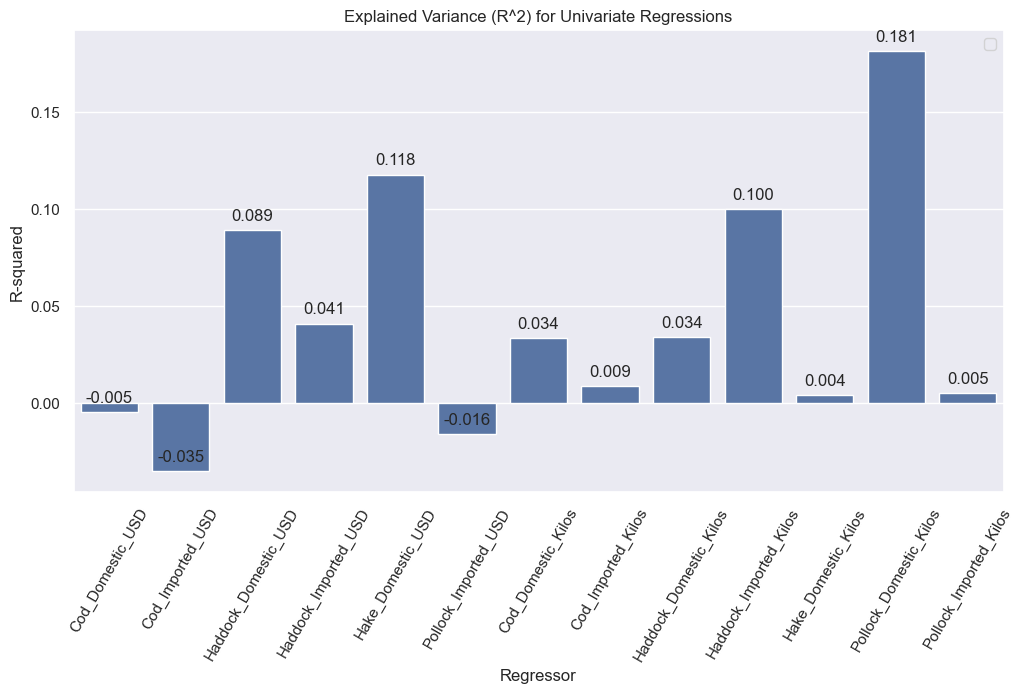

In [33]:

sns.barplot(data=results_df, x='Regressor', y='R-squared')
for i, value in enumerate(results_df['R-squared'].values):
    plt.text(i, (value + 0.005), '{:.3f}'.format(value), ha='center')
plt.title(r'Explained Variance (R^2) for Univariate Regressions')
plt.xticks(rotation=60)
plt.legend()
plt.show()

In [34]:
X_simple = X[['Cod_Imported_USD']]

model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X_simple, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
residuals = y_test - y_pred

score = model.score(X_test, y_test)

# Calculate and print coefficients
print("Model score:", score)

# Calculate and print the intercept
print("Intercept:", model.intercept_)

# Calculate and print the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Model score: -0.035076528168078935
Intercept: [5.9317424]
Mean Squared Error: 2.347734844583591
R-squared: -0.035076528168078935


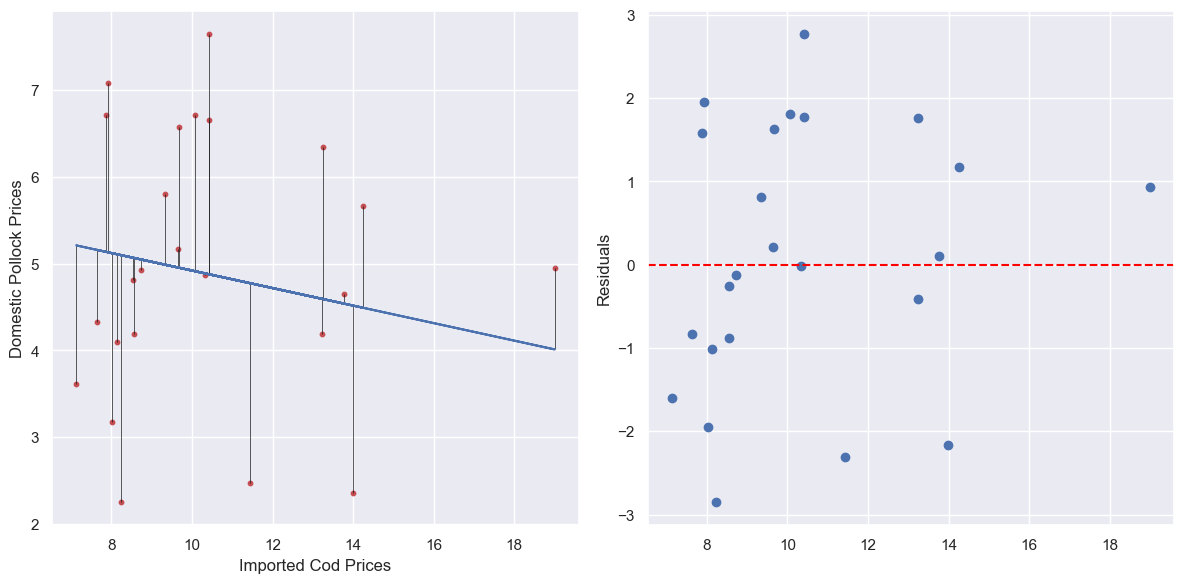

In [35]:
# plot regression and residuals

fig, ax = plt.subplots(1, 2)

ax[0].vlines(X_test, ymin=y_test, ymax=y_pred, color='k', linewidth=.5)
ax[0].scatter(X_test, y_test, c='r', s=10)
ax[0].plot(X_test, y_pred, c='b')
ax[0].set_ylabel('Domestic Pollock Prices')
ax[0].set_xlabel('Imported Cod Prices')


ax[1].scatter(X_test, residuals)
ax[1].axhline(0, color='red', linestyle='--')  
ax[1].set_ylabel('Residuals')
ax[1].set_xlabel('')

plt.tight_layout()
plt.show();

In [36]:
import statsmodels.api as sm

X_statsmodel = sm.add_constant(X_simple) 
statsmodel = sm.OLS(y.values, X_statsmodel).fit()  

# results
print(statsmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.194
Date:                Mon, 15 Apr 2024   Prob (F-statistic):              0.277
Time:                        16:40:16   Log-Likelihood:                -211.33
No. Observations:                 120   AIC:                             426.7
Df Residuals:                     118   BIC:                             432.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.5989      0.645  

## Multi LinearRegression

### Scaling

In [37]:

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

### Check Statsmodel for Linear Regression fit data

In [38]:
import statsmodels.api as sm

X_statsmodel = sm.add_constant(X_scaled) 
statsmodel = sm.OLS(y.values, X_statsmodel).fit()  

# results
print(statsmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     8.769
Date:                Mon, 15 Apr 2024   Prob (F-statistic):           6.77e-12
Time:                        16:40:16   Log-Likelihood:                -168.12
No. Observations:                 120   AIC:                             364.2
Df Residuals:                     106   BIC:                             403.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4

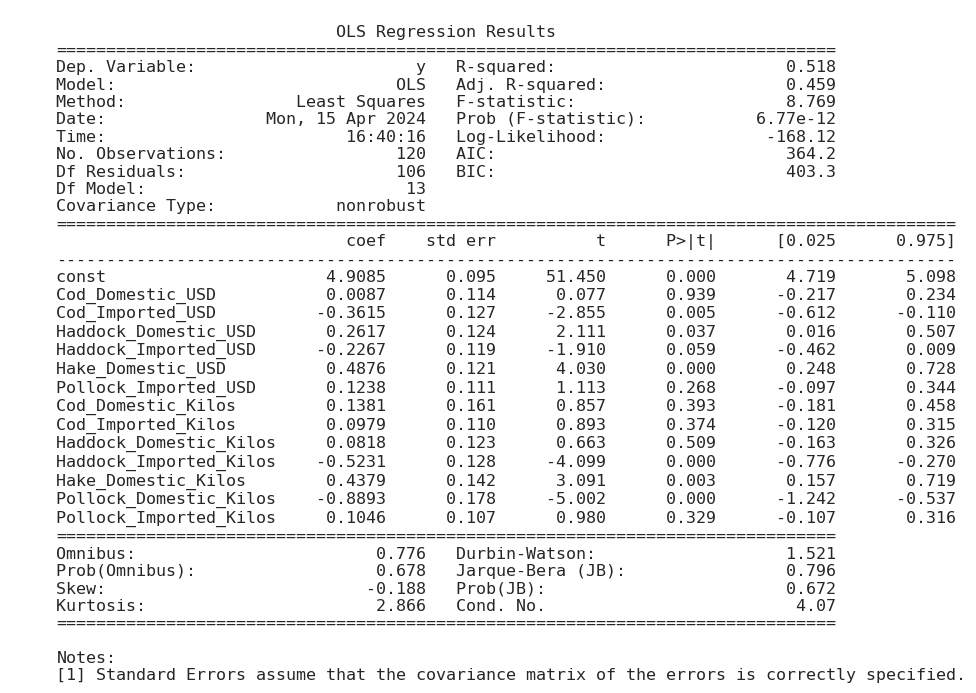

In [39]:
summary_text = statsmodel.summary().as_text()

# Create a figure and plot the text as annotation
plt.figure(figsize=(6, 4))
plt.text(0.1, 0.95, summary_text, va='top', family='monospace')
plt.axis('off')  # Turn off axes
plt.savefig('figs/statmodel_summary', bbox_inches='tight')
plt.show()



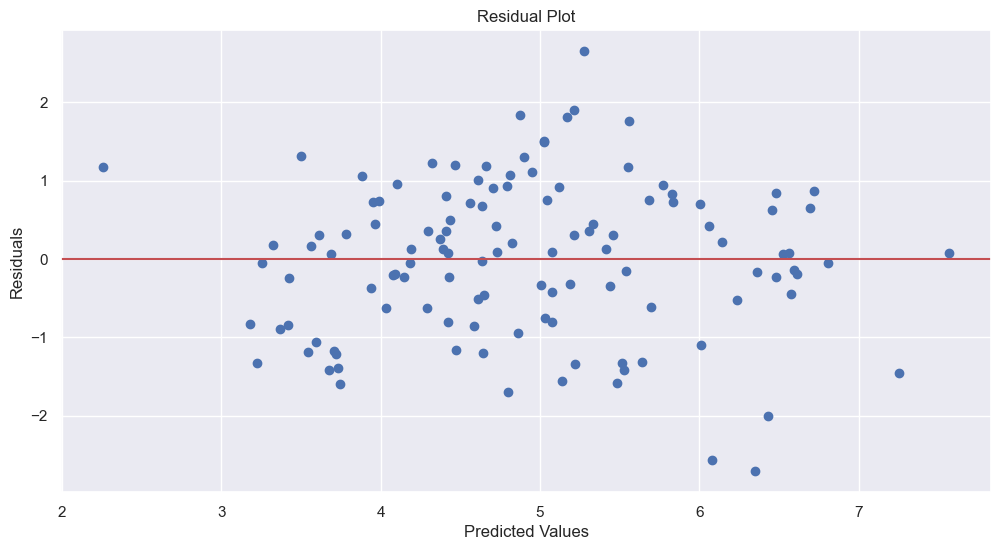

In [40]:
# get residuals
residuals = statsmodel.resid


# Plot residuals against predicted values
plt.scatter(statsmodel.fittedvalues, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')  
plt.show()

### Multi Linear Regression

Model score: 0.5823919767940073
Intercept: [4.92655315]
Mean Squared Error: 0.9472081346425587
R-squared: 0.5823919767940073
                        Coefficients
Cod_Domestic_USD            0.033285
Cod_Imported_USD           -0.485076
Haddock_Domestic_USD        0.243901
Haddock_Imported_USD       -0.270571
Hake_Domestic_USD           0.443010
Pollock_Imported_USD        0.093093
Cod_Domestic_Kilos          0.097106
Cod_Imported_Kilos          0.066591
Haddock_Domestic_Kilos     -0.005962
Haddock_Imported_Kilos     -0.492342
Hake_Domestic_Kilos         0.413950
Pollock_Domestic_Kilos     -0.827944
Pollock_Imported_Kilos      0.076919


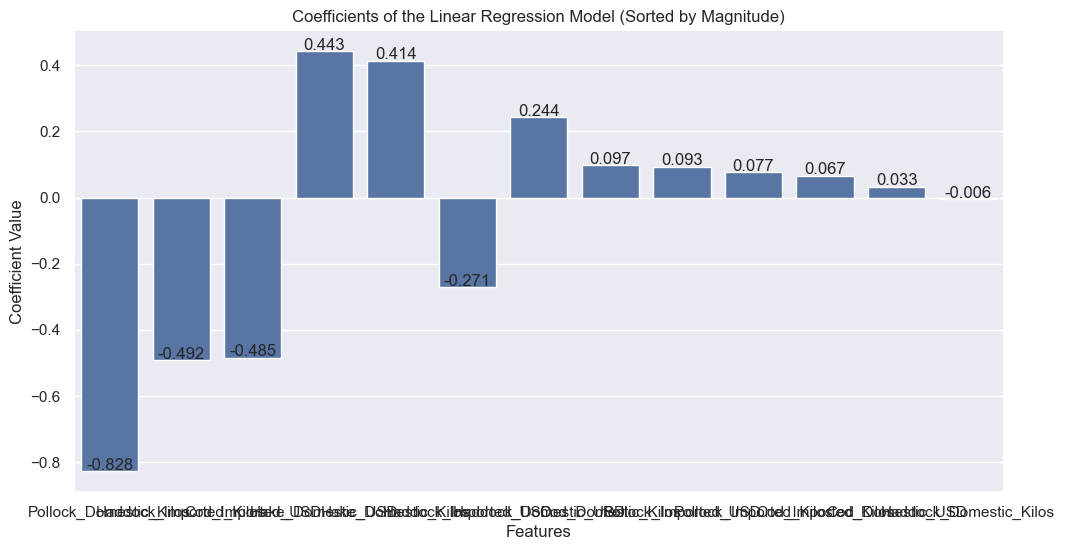

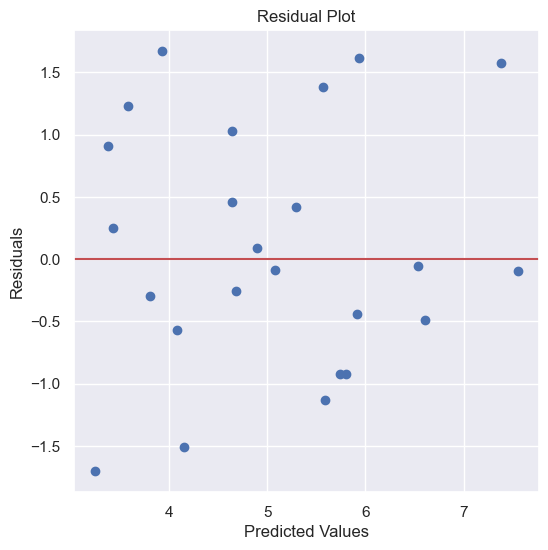

In [41]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
residuals = y_test - y_pred

score = model.score(X_test, y_test)
# evaluate 
print("Model score:", score)
print("Intercept:", model.intercept_)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# get coef dataframe
coef_df = pd.DataFrame(model.coef_.ravel(), X.columns, columns=['Coefficients'])
print(coef_df)

# plot coef magnitudes
coef_df['Abs_Coefficients'] = coef_df['Coefficients'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficients', ascending=False)
#sorted_coef_df['Coefficients'].plot(kind='bar', legend=False)
sns.barplot(sorted_coef_df['Coefficients'])
for i, value in enumerate(sorted_coef_df['Coefficients'].values):
    plt.text(i, (value + 0.005), '{:.3f}'.format(value), ha='center')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of the Linear Regression Model (Sorted by Magnitude)')
plt.show()

# get residuals
residuals = y_pred - y_test

# Plot residuals against predicted values
plt.figure(figsize=(6,6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')  
plt.show()


# Multi Linear Regression with PCA 

Model score: 0.582628997373614
Intercept: [4.89311077]
Mean Squared Error: 1.0839530368838926
R-squared: 0.5221034655154911
Best Parameters: {'pca__n_components': 11}
Explained Variance Ratios
    n_components  Percentage of Explained Variance
0              1                          0.227042
1              2                          0.188335
2              3                          0.125004
3              4                          0.098075
4              5                          0.060960
5              6                          0.060217
6              7                          0.056223
7              8                          0.049617
8              9                          0.040959
9             10                          0.030152
10            11                          0.028594


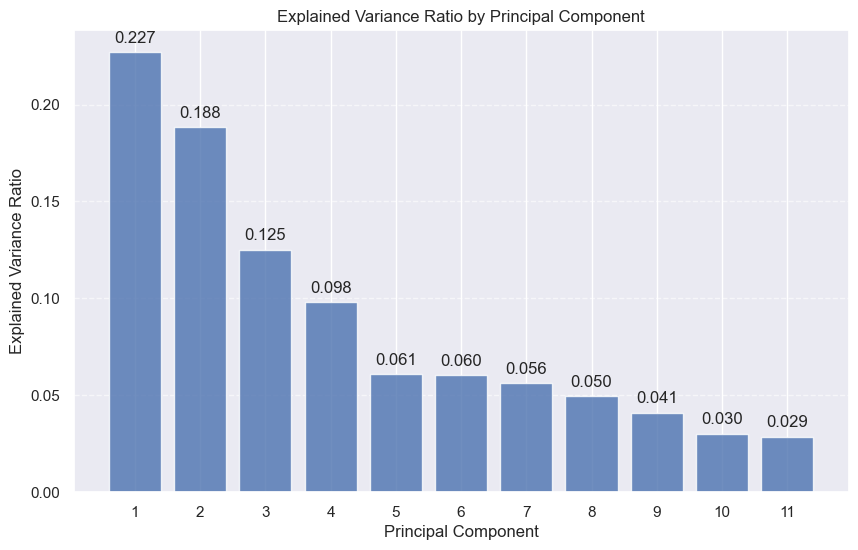

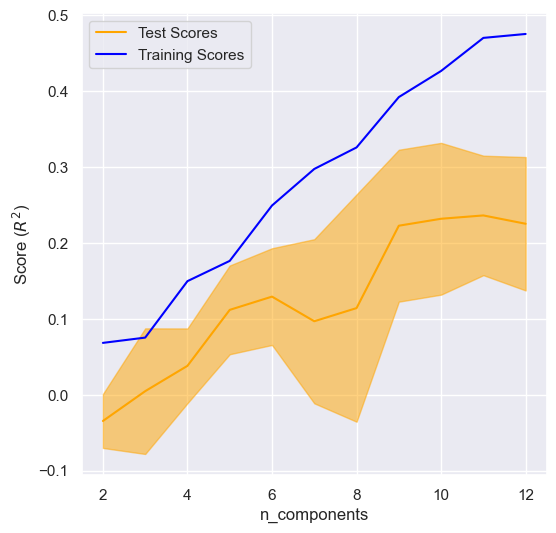

In [61]:

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a pipe
pipeline = Pipeline([
    ('pca', PCA()),
    ('regression', LinearRegression())
])

# PCA values for gridsearch
param_grid = {
    'pca__n_components': np.arange(2, X.shape[1])  # Specify the range of n_components to search over
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Predict on the test data using the best model
y_pred = best_model.predict(X_test)
residuals = y_test-y_pred

# Get results dict
results_df = pd.DataFrame(grid_search.cv_results_)

# Evaluate
print("Model score:", score)
print("Intercept:", best_model.named_steps['regression'].intercept_)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
print("Best Parameters:", grid_search.best_params_)

# explained variance
best_pca = best_model.named_steps['pca']
explained_variance_ratio = best_pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame({
    'n_components': np.arange(1, len(explained_variance_ratio) + 1),
    'Percentage of Explained Variance': explained_variance_ratio
})
print('Explained Variance Ratios')
print(explained_variance_df)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.8)
for i, value in enumerate(explained_variance_ratio):
    plt.text(i+1, (abs(value) + 0.005), '{:.3f}'.format(value), ha='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# plot text train scores
plt.figure(figsize=(6,6))
plt.plot(results_df['param_pca__n_components'], results_df[['mean_test_score']], label='Test Scores', c='orange')
plt.plot(results_df['param_pca__n_components'], results_df[['mean_train_score']], label='Training Scores', c='blue')
plt.fill_between(x=results_df['param_pca__n_components'].astype(float), 
                 y1=results_df['mean_test_score'] + results_df['std_test_score'], 
                 y2=results_df['mean_test_score'] - results_df['std_test_score'], 
                 color='orange', alpha=0.5)
plt.xlabel('n_components')
plt.ylabel(r'Score ($R^2$)')
plt.legend()
plt.show();

In [62]:
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.5221034655154911


In [63]:
results_df

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.001874      0.000249         0.000890        0.000189   
1        0.001170      0.000158         0.000651        0.000033   
2        0.001328      0.000231         0.000690        0.000036   
3        0.001271      0.000121         0.000662        0.000029   
4        0.001225      0.000152         0.000699        0.000070   
5        0.001268      0.000221         0.000644        0.000021   
6        0.001254      0.000185         0.000663        0.000022   
7        0.001046      0.000031         0.000611        0.000028   
8        0.000984      0.000009         0.000584        0.000001   
9        0.000968      0.000008         0.000580        0.000003   
10       0.001087      0.000083         0.000674        0.000116   

   param_pca__n_components                     params  split0_test_score  \
0                        2   {'pca__n_components': 2}          -0.084952   
1                        3   {'pca__n_components': 3}          -0.087775   
2                        4   {'pca__n_components': 4}          -0.018962   
3                        5   {'pca__n_components': 5}           0.127624   
4                        6   {'pca__n_components': 6}           0.127891   
5                        7   {'pca__n_components': 7}           0.094563   
6                        8   {'pca__n_components': 8}           0.081981   
7                        9   {'pca__n_components': 9}           0.090721   
8                       10  {'pca__n_components': 10}           0.103429   
9                       11  {'pca__n_components': 11}           0.129792   
10                      12  {'pca__n_components': 12}           0.104168   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           -0.011793          -0.007547        -0.034764        0.035530   
1           -0.011638           0.112915         0.004501        0.082722   
2            0.031471           0.101137         0.037882        0.049240   
3            0.033362           0.173791         0.111593        0.058440   
4            0.051657           0.207646         0.129065        0.063688   
5           -0.034744           0.230001         0.096607        0.108091   
6           -0.051296           0.311151         0.113945        0.149685   
7            0.243635           0.333038         0.222464        0.100052   
8            0.244084           0.347339         0.231617        0.099965   
9            0.260273           0.317930         0.235998        0.078702   
10           0.260505           0.310424         0.225032        0.087860   

    rank_test_score  split0_train_score  split1_train_score  \
0                11            0.104335            0.076666   
1                10            0.105104            0.079717   
2                 9            0.218564            0.181073   
3                 7            0.271899            0.181183   
4                 5            0.272753            0.185341   
5                 8            0.358737            0.207958   
6                 6            0.362307            0.269681   
7                 4            0.377163            0.450731   
8                 2            0.475424            0.451216   
9                 1            0.501144            0.476124   
10                3            0.512475            0.476126   

    split2_train_score  mean_train_score  std_train_score  
0             0.023341          0.068114         0.033614  
1             0.040386          0.075069         0.026625  
2             0.048673          0.149437         0.072876  
3             0.075324          0.176135         0.080331  
4             0.289078          0.249058         0.045545  
5             0.324990          0.297228         0.064610  
6             0.344747          0.325578         0.040170  
7             0.347785          0.391893         0.043299  
8             0.352298          0.426312         0.0

## Ridge Regression (Naive, alpha=1)

Model score: 0.582628997373614
Intercept: [4.92567128]
Mean Squared Error: 0.9466705304572809
R-squared: 0.582628997373614
                        Coefficients
Cod_Domestic_USD            0.026096
Cod_Imported_USD           -0.469805
Haddock_Domestic_USD        0.247762
Haddock_Imported_USD       -0.269297
Hake_Domestic_USD           0.430867
Pollock_Imported_USD        0.090494
Cod_Domestic_Kilos          0.085019
Cod_Imported_Kilos          0.069397
Haddock_Domestic_Kilos     -0.009231
Haddock_Imported_Kilos     -0.488516
Hake_Domestic_Kilos         0.401501
Pollock_Domestic_Kilos     -0.793609
Pollock_Imported_Kilos      0.074744


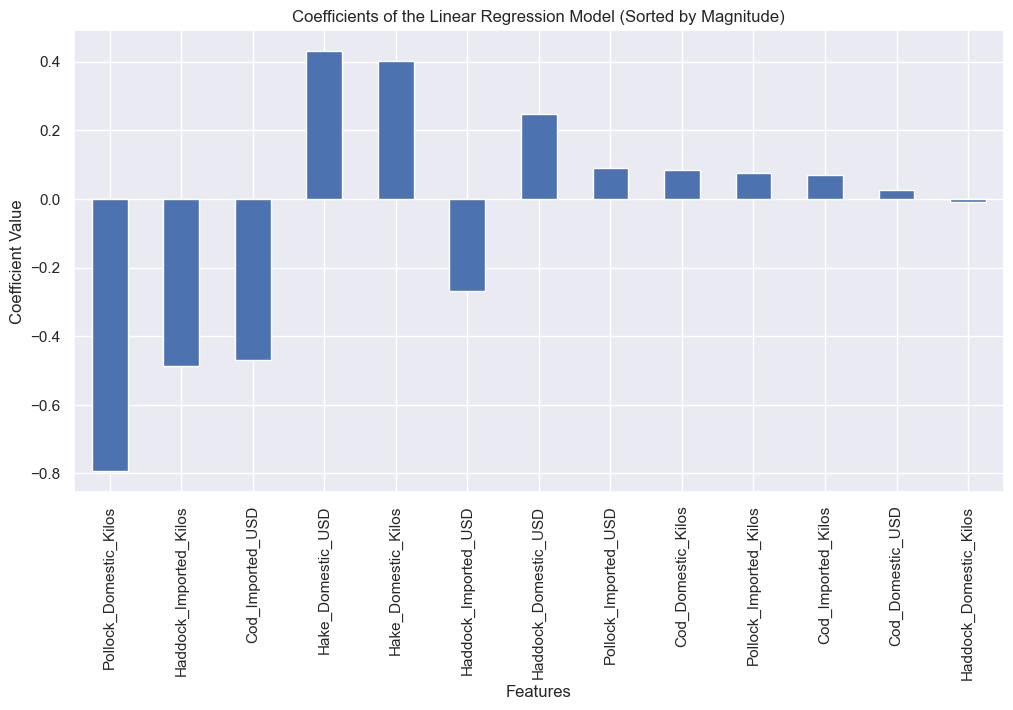

In [43]:
from sklearn.linear_model import Ridge

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

ridge_model = Ridge(alpha=1.0)

# Fit the model to the training data
ridge_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = ridge_model.predict(X_test)
residuals = y_test - y_pred

# Evaluate
score = ridge_model.score(X_test, y_test)
print("Model score:", score)
print("Intercept:", ridge_model.intercept_)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# make coef dataframe
coef_df = pd.DataFrame(ridge_model.coef_.ravel(), X.columns, columns=['Coefficients'])
print(coef_df)


# plot coefs
coef_df['Abs_Coefficients'] = coef_df['Coefficients'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficients', ascending=False)
sorted_coef_df['Coefficients'].plot(kind='bar', legend=False)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of the Linear Regression Model (Sorted by Magnitude)')
plt.show()

## Ridge Regression with Gridsearch over alphas

Best alpha: 16.338538778098602
Mean Squared Error with best alpha: 1.0267137619617692
R-squared: 0.5473392923372198
                        Coefficients
Cod_Domestic_USD           -0.013713
Cod_Imported_USD           -0.322701
Haddock_Domestic_USD        0.257475
Haddock_Imported_USD       -0.242279
Hake_Domestic_USD           0.313578
Pollock_Imported_USD        0.070250
Cod_Domestic_Kilos          0.002544
Cod_Imported_Kilos          0.086202
Haddock_Domestic_Kilos     -0.043543
Haddock_Imported_Kilos     -0.415979
Hake_Domestic_Kilos         0.282072
Pollock_Domestic_Kilos     -0.503658
Pollock_Imported_Kilos      0.056626


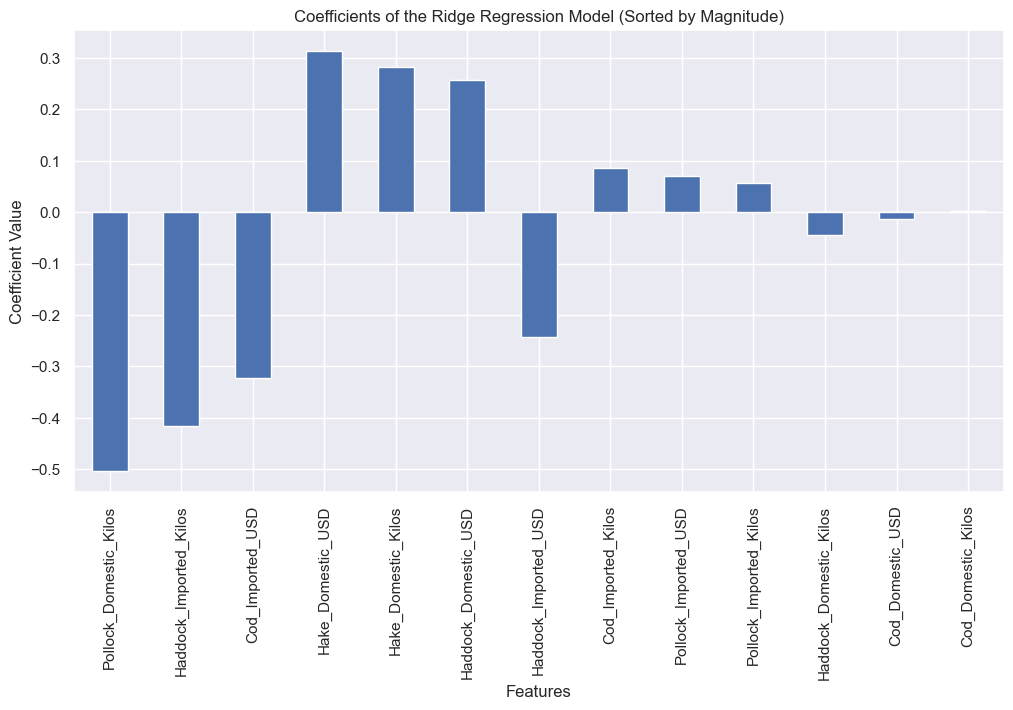

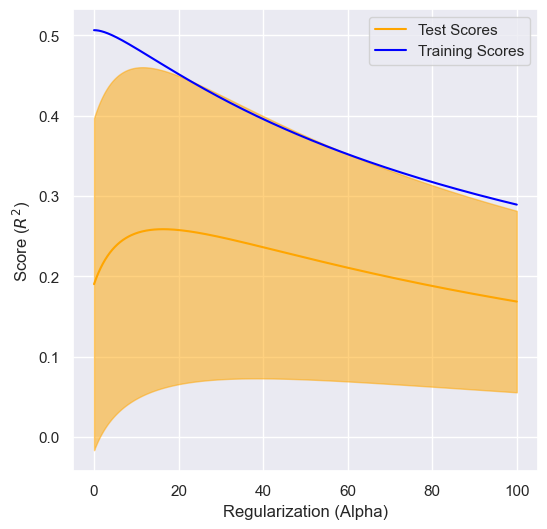

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the model
ridge = Ridge()

# Params for gridsearch
alphas = np.logspace(-4, 2, 1000)

# Define the grid search with cross-validation
grid = GridSearchCV(estimator=ridge, param_grid={'alpha': alphas}, scoring='r2', cv=5, return_train_score=True)

# Fit the grid search to the data
grid.fit(X_train, y_train)

# Get the best alpha
best_alpha = grid.best_params_['alpha']
print("Best alpha:", best_alpha)

# Refit the Ridge model with the best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)

# Get results dict
results_df = pd.DataFrame(grid.cv_results_)

# Evaluate the model
y_pred = ridge_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error with best alpha:", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

coef_df = pd.DataFrame(ridge_best.coef_.ravel(), X.columns, columns=['Coefficients'])
print(coef_df)

coef_df['Abs_Coefficients'] = coef_df['Coefficients'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficients', ascending=False)
sorted_coef_df['Coefficients'].plot(kind='bar', legend=False)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of the Ridge Regression Model (Sorted by Magnitude)')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(results_df['param_alpha'], results_df[['mean_test_score']], label='Test Scores', c='orange')
plt.plot(results_df['param_alpha'], results_df[['mean_train_score']], label='Training Scores', c='blue')
plt.fill_between(x=results_df['param_alpha'].astype(float), 
                 y1=results_df['mean_test_score'] + results_df['std_test_score'], 
                 y2=results_df['mean_test_score'] - results_df['std_test_score'], 
                 color='orange', alpha=0.5)
plt.xlabel('Regularization (Alpha)')
plt.ylabel(r'Score ($R^2$)')
plt.legend()
plt.show();


## Lasso Regression

Best alpha: 0.05898896425508499
Mean Squared Error with best alpha: 0.9471284759470696
R-squared: 0.5824270969636276
                        Coefficients
Cod_Domestic_USD            0.032828
Cod_Imported_USD           -0.484143
Haddock_Domestic_USD        0.244152
Haddock_Imported_USD       -0.270500
Hake_Domestic_USD           0.442267
Pollock_Imported_USD        0.092931
Cod_Domestic_Kilos          0.096346
Cod_Imported_Kilos          0.066768
Haddock_Domestic_Kilos     -0.006159
Haddock_Imported_Kilos     -0.492127
Hake_Domestic_Kilos         0.413188
Pollock_Domestic_Kilos     -0.825820
Pollock_Imported_Kilos      0.076784


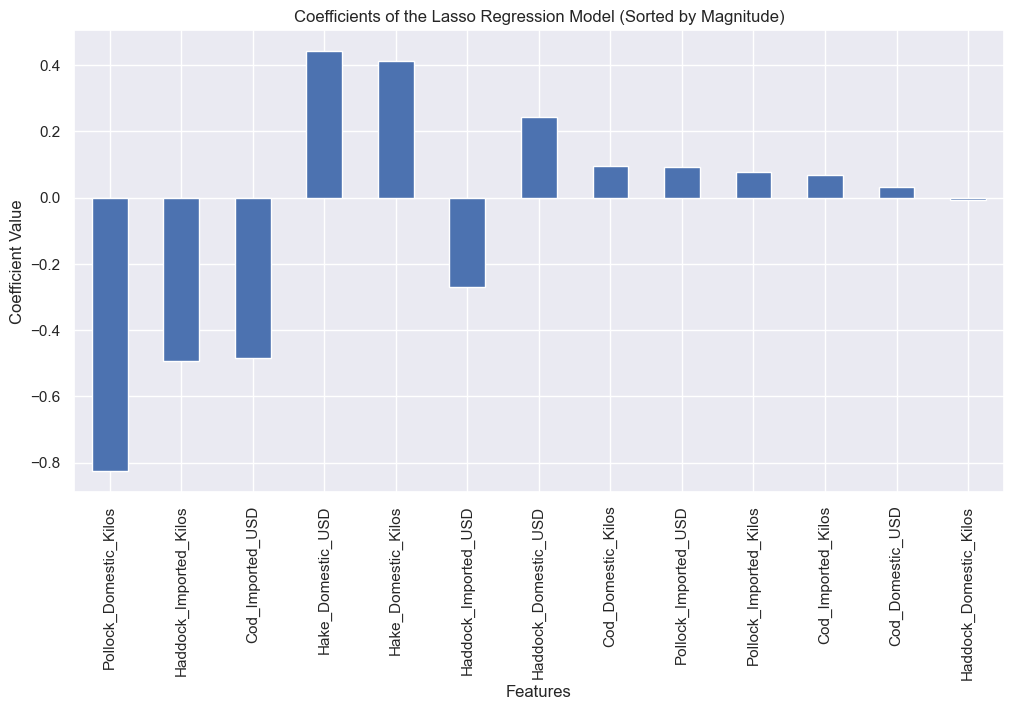

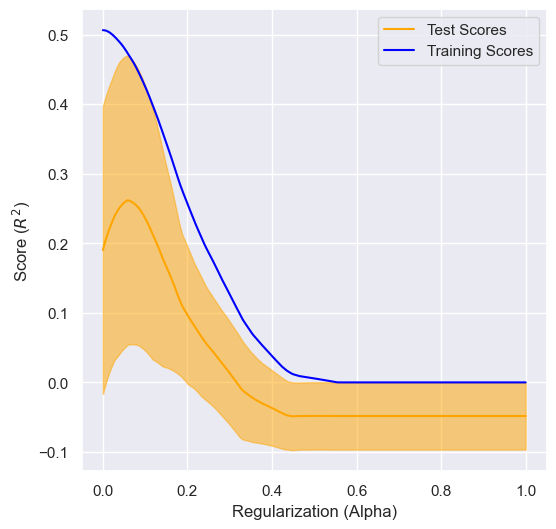

In [45]:

from sklearn.linear_model import Lasso

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the model
lasso = Lasso()

# Params for gridsearch
alphas = np.logspace(-4, 0, 1000)

# Define the grid search with cross-validation
grid = GridSearchCV(estimator=lasso, param_grid={'alpha': alphas}, scoring='r2', cv=5, return_train_score=True)

# Fit the grid search to the data
grid.fit(X_train, y_train)

# Get the best alpha
best_alpha = grid.best_params_['alpha']
print("Best alpha:", best_alpha)

# Refit the Ridge model with the best alpha
lasso_best = Ridge(alpha=best_alpha)
lasso_best.fit(X_train, y_train)

# Get results dict
results_df = pd.DataFrame(grid.cv_results_)

# Evaluate the model
y_pred = lasso_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error with best alpha:", mse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# coef dataframe
coef_df = pd.DataFrame(lasso_best.coef_.ravel(), X.columns, columns=['Coefficients'])
print(coef_df)

# plot coefficient magnitude
coef_df['Abs_Coefficients'] = coef_df['Coefficients'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficients', ascending=False)
sorted_coef_df['Coefficients'].plot(kind='bar', legend=False)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of the Lasso Regression Model (Sorted by Magnitude)')
plt.show()

# plot train vs test score
plt.figure(figsize=(6,6))
plt.plot(results_df['param_alpha'], results_df[['mean_test_score']], label='Test Scores', c='orange')
plt.plot(results_df['param_alpha'], results_df[['mean_train_score']], label='Training Scores', c='blue')
plt.fill_between(x=results_df['param_alpha'].astype(float), 
                 y1=results_df['mean_test_score'] + results_df['std_test_score'], 
                 y2=results_df['mean_test_score'] - results_df['std_test_score'], 
                 color='orange', alpha=0.5)
plt.xlabel('Regularization (Alpha)')
plt.ylabel(r'Score ($R^2$)')
#plt.ylim(0, 2.5)
plt.legend()
plt.show();


Computing regularization path using the LARS ...
.Coefficient Order:
['Pollock_Domestic_Kilos', 'Haddock_Domestic_USD', 'Haddock_Imported_Kilos', 'Hake_Domestic_USD', 'Haddock_Imported_USD', 'Cod_Imported_USD', 'Hake_Domestic_Kilos', 'Cod_Imported_Kilos', 'Pollock_Imported_Kilos', 'Pollock_Imported_USD', 'Cod_Domestic_Kilos', 'Haddock_Domestic_Kilos', 'Cod_Domestic_USD']


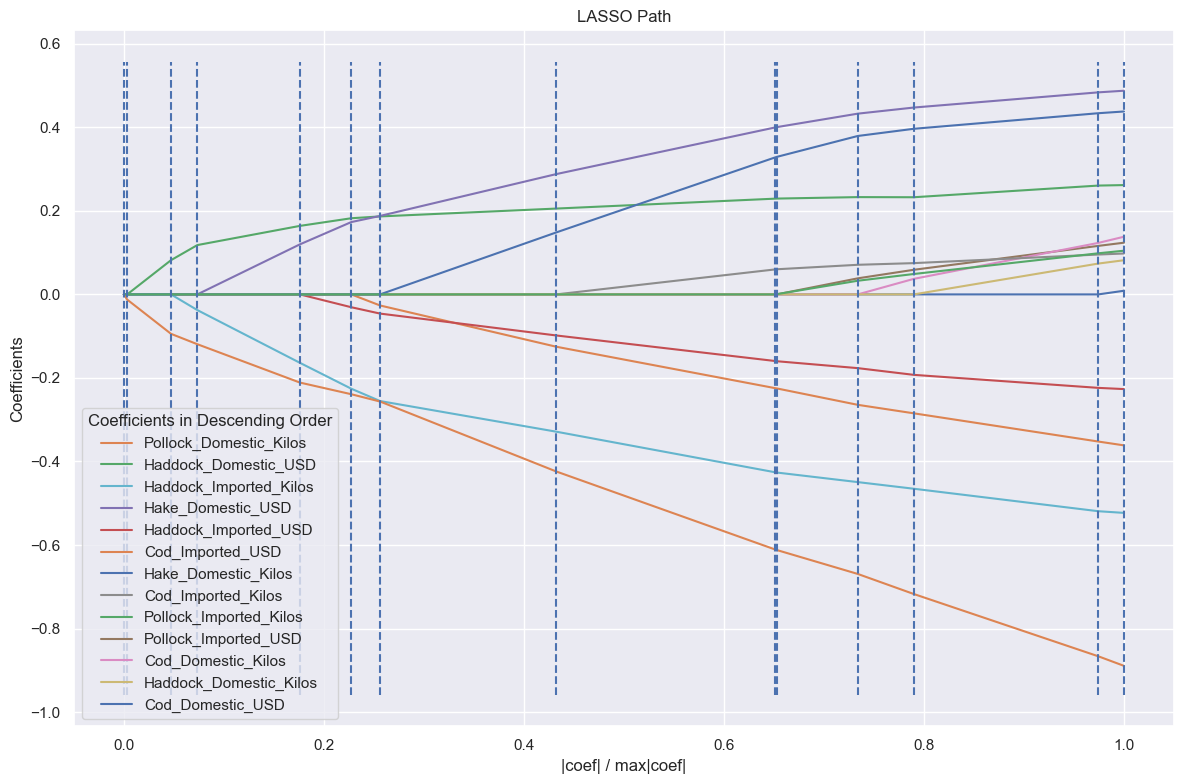

In [46]:
from sklearn.linear_model import lars_path

X_array = X_scaled.to_numpy()
y_array = y.to_numpy().ravel()


## LARS PATH
print("Computing regularization path using the LARS ...")
_, _, coefs = lars_path(X_array, y_array, method="lasso", verbose=True)

# make a coef dataframe with a col for each feature
coef_df = pd.DataFrame(coefs.T, columns=X_scaled.columns.values)

# normalize xx value
xx_df = pd.DataFrame()
xx_df['xx'] = np.sum(np.abs(coefs.T), axis=1)
xx_df['xx'] /= xx_df['xx'].iloc[-1]

# create coef_order dict
coef_order_dict = coef_df.apply(lambda x: x[x != 0].index[0] if any(x != 0) else np.nan).to_dict()

# create list of features sorted by coef_order_dict mappng
coef_order_list = sorted(coef_order_dict, key=coef_order_dict.get)
print('Coefficient Order:')
print(coef_order_list)

## plot
plt.figure(figsize=(12, 8))

# plot path for each coef
for col in coef_df.columns:
    plt.plot(xx_df['xx'], coef_df[col], label=col)

# plot vertical lines at branches
ymin, ymax = plt.ylim()
plt.vlines(xx_df, ymin, ymax, linestyle="dashed")

# order the legend using coef_order_dict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
sorted_handles = [by_label[label] for label in sorted(coef_order_dict, key=coef_order_dict.get)]
sorted_labels = sorted(coef_order_dict, key=coef_order_dict.get)
plt.legend(sorted_handles, sorted_labels, title='Coefficients in Descending Order')

# plot attributes
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.title("LASSO Path")
plt.grid(True)
plt.tight_layout()
plt.show()
